# HR-анализ: оптимизация управления персоналом

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

**<u>Задачи:</u>**

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Задача первая: предсказание уровня удовлетворенности сотрудника

**<u>Описание данных</u>**

Для работы предоставлено **три датасета**: 
* `train_job_satisfaction_rate.csv` — тренировочная выборка
* `test_features.csv` — входные признаки тестовой выборки
* `test_target_job_satisfaction_rate.csv` — целевой признак тестовой выборки

**Признаковое пространство** для исследования:
* `id` — уникальный идентификатор сотрудника;
* `dept` — отдел, в котором работает сотрудник;
* `level` — уровень занимаемой должности;
* `workload` — уровень загруженности сотрудника;
* `employment_years` — длительность работы в компании (в годах);
* `last_year_promo` — показывает, было ли повышение за последний год;
* `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
* `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
* `salary` — ежемесячная зарплата сотрудника;
* `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

**<u>План работы</u>**

1. **Загрузка данных**

Открыть предоставленные файлы, убедиться, что данные в таблицах соответствуют описанию.

2. **Предобработка данных**

Изучить данные и сделать выводы. При необходимости выполнить предобработку. Если есть пропуски, заполнить их в пайплайне.

3. **Исследовательский анализ данных**

Исследовать все признаки и сделать выводы о том, как их нужно подготовить.

4. **Подготовка данных**

Подготовку признаков выполнить в пайплайне, дополнив пайплайн шага предобработки. При кодировании учесть особенности признаков и моделей и использовать как минимум два кодировщика.

5. **Обучение моделей**

Обучить как минимум две модели. Взять одну линейную модель, а в качестве второй — дерево решений. Подобрать гиперпараметры как минимум для одной модели с помощью одного из известных инструментов.

Выбрать лучшую модель и проверить её качество. Выбор делать на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).

Написать функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE. Использовать эту метрику при подборе гиперпараметров и оценке качества моделей. Критерий успеха: SMAPE ≤ 15 на тестовой выборке.
В решении сохранить работу со всеми моделями, которые были опробованы. Сделать выводы.

6. **Выводы**

Сделать выводы о том, какая модель справилась лучше и почему.

### Загрузка данных

In [1]:
# установим недостающие библиотеки
! pip install shap -q
! pip install phik -q
! pip install scikit-learn==1.3.2 -q

In [2]:
# импортируем необходимые для работы библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import phik

from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', None)

%matplotlib inline

RANDOM_STATE=42

In [3]:
# сохраним датафреймы в переменные
train_data = pd.read_csv('datasets/train_job_satisfaction_rate.csv')
test_data = pd.read_csv('datasets/test_features.csv')
target_data = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv')

# отдельно сохраним датафрейм с целевым признаком удовлетворенности работой для использования во второй задаче
target_data_for_task_2 = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv')

In [4]:
# просмотрим первые строки первого датафрейма
train_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
# просмотрим общую информацию о датафрейме
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Датафрейм `train_data` состоит из `4000` строк и `10` столбцов, есть незначительное количество пропусков, данные представлены целочисленными, вещественными и строковыми значениями.

In [6]:
# просмотрим первые строки второго датафрейма
test_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [7]:
# просмотрим общую информацию о датафрейме
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Датафрейм `test_data` состоит из `2000` строк и `9` столбцов, также есть незначительное количество пропусков, данные представлены целочисленными и строковыми значениями.

In [8]:
# просмотрим первые строки третьего датафрейма
target_data.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [9]:
# просмотрим общую информацию о датафрейме
target_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Датафрейм `target_data` состоит из `2000` строк и `2` столбцов, пропусков нет, данные представлены целочисленными и вещественными значениями.

**Вывод**

Для работы предоставлено три датафрейма: тренирочая выборка, входные признаки тестовой выборки и целевой признак тестовой выборки. Все типы данных соотвествуют тем, которые даны в описании к названиям признаков. В датафреймах `train_data` (тренировочная выборка) и `test_data` (входные признаки тестовой выборки) имеется незначительное количество пропусков.

### Предобработка данных

Как было замечено выше, в двух датафреймах есть пропуски, удалять или каким-то образом обрабатывать их будем на следующем этапе.
А пока начнем поиск и обработку дубликатов и других аномалий. Для начала проверим наличие уникальных строковых значений в датафреймах `train_data` и `test_data`, чтобы выявить опечатки в данных, датафрейм `target_data` не содержит строковых значений.

In [10]:
# рассмотрим датафрейм train_data
unique_values_dept = train_data['dept'].unique()
unique_values_level = train_data['level'].unique()
unique_values_workload = train_data['workload'].unique()
unique_values_last_year_promo = train_data['last_year_promo'].unique()
unique_values_last_year_violations = train_data['last_year_violations'].unique()

print("Датафрейм 'train_data'")
print("------------------------------")
print("Уникальные значения в столбце 'dept':")
print(unique_values_dept)
print("------------------------------")
print("Уникальные значения в столбце 'level':")
print(unique_values_level)
print("------------------------------")
print("Уникальные значения в столбце 'workload':")
print(unique_values_workload)
print("------------------------------")
print("Уникальные значения в столбце 'last_year_promo':")
print(unique_values_last_year_promo)
print("------------------------------")
print("Уникальные значения в столбце 'last_year_violations':")
print(unique_values_last_year_violations)

Датафрейм 'train_data'
------------------------------
Уникальные значения в столбце 'dept':
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
------------------------------
Уникальные значения в столбце 'level':
['junior' 'middle' 'sinior' nan]
------------------------------
Уникальные значения в столбце 'workload':
['medium' 'high' 'low']
------------------------------
Уникальные значения в столбце 'last_year_promo':
['no' 'yes']
------------------------------
Уникальные значения в столбце 'last_year_violations':
['no' 'yes']


In [11]:
# рассмотрим датафрейм test_data
unique_values_dept = test_data['dept'].unique()
unique_values_level = test_data['level'].unique()
unique_values_workload = test_data['workload'].unique()
unique_values_last_year_promo = test_data['last_year_promo'].unique()
unique_values_last_year_violations = test_data['last_year_violations'].unique()

print("Датафрейм 'test_data'")
print("------------------------------")
print("Уникальные значения в столбце 'dept':")
print(unique_values_dept)
print("------------------------------")
print("Уникальные значения в столбце 'level':")
print(unique_values_level)
print("------------------------------")
print("Уникальные значения в столбце 'workload':")
print(unique_values_workload)
print("------------------------------")
print("Уникальные значения в столбце 'last_year_promo':")
print(unique_values_last_year_promo)
print("------------------------------")
print("Уникальные значения в столбце 'last_year_violations':")
print(unique_values_last_year_violations)

Датафрейм 'test_data'
------------------------------
Уникальные значения в столбце 'dept':
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
------------------------------
Уникальные значения в столбце 'level':
['junior' 'middle' 'sinior' nan]
------------------------------
Уникальные значения в столбце 'workload':
['medium' 'low' 'high' ' ']
------------------------------
Уникальные значения в столбце 'last_year_promo':
['no' 'yes']
------------------------------
Уникальные значения в столбце 'last_year_violations':
['no' 'yes']


В столбцах `dept` и `workload` датафрейма `test_data` есть пустые строки, заменим их на `nan` далее в пайплайне.

Теперь проверим, есть ли в датафреймах явные дубликаты.

In [12]:
train_data.duplicated().sum()

0

In [13]:
test_data.duplicated().sum()

0

In [14]:
target_data.duplicated().sum()

0

Явных дубликатов не обнаружено.

**Вывод**

В датафремах нет явных дубликатов. Обнаруженные пустые строки и пропуски будут обработаны в пайплайне в соответствии с заданием.

### Исследовательский анализ данных

Для начала просмотрим сводную информацию о датафреймах.

In [15]:
# просмотрим статистику датафрейма train_data
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


In [16]:
# просмотрим статистику датафрейма test_data
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


In [17]:
# просмотрим статистику датафрейма target_data
target_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


При просмотре данных статистики этих датафреймов, мы видим, что данные согласованы и лежат в одинаковых диапазонах. На первый взгляд никаких аномалий не наблюдается. Нужно проверить данные графически. 

**1.** Начнем с тренировочной выборки — датафрейм `train_data`.

In [18]:
# определим количественные, категориальные признаки и целевую переменную
num_features = ['employment_years', 'supervisor_evaluation', 'salary']
cat_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
target_feature = 'job_satisfaction_rate'

Для удобства построения графиков и избежания дублирования кода напишем функции: будем строить **гистограммы и ящики с усами** для количественных признаков и **столбчатые диаграммы** для категориальных признаков.

In [19]:
# функция для построения гистограммы и ящика с усами
def create_hist_and_boxplot(data, num_feature):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # слева гистограмма
    axes[0].hist(data[num_feature], bins=10, color='lightblue')
    axes[0].set_xlabel(num_feature)
    axes[0].set_ylabel('Частота')
    axes[0].set_title(f'Гистограмма {num_feature}')

    # справа ящик с усами
    sns.boxplot(x=data[num_feature], ax=axes[1], color='lightgreen')
    axes[1].set_xlabel(num_feature)
    axes[1].set_ylabel('Значение')
    axes[1].set_title(f'Боксплот {num_feature}')

    plt.tight_layout()
    plt.show()

    
# функция для построения столбчатой диаграммы  
def create_barplot(data, cat_feature):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=cat_feature, data=data, palette='coolwarm')
    plt.xlabel(cat_feature)
    plt.ylabel('Количество')
    plt.title(f'Столбчатая диаграмма {cat_feature}')
    plt.xticks(rotation=45)
    plt.show()

Построим графики для оценки распределения **количественных признаков**.

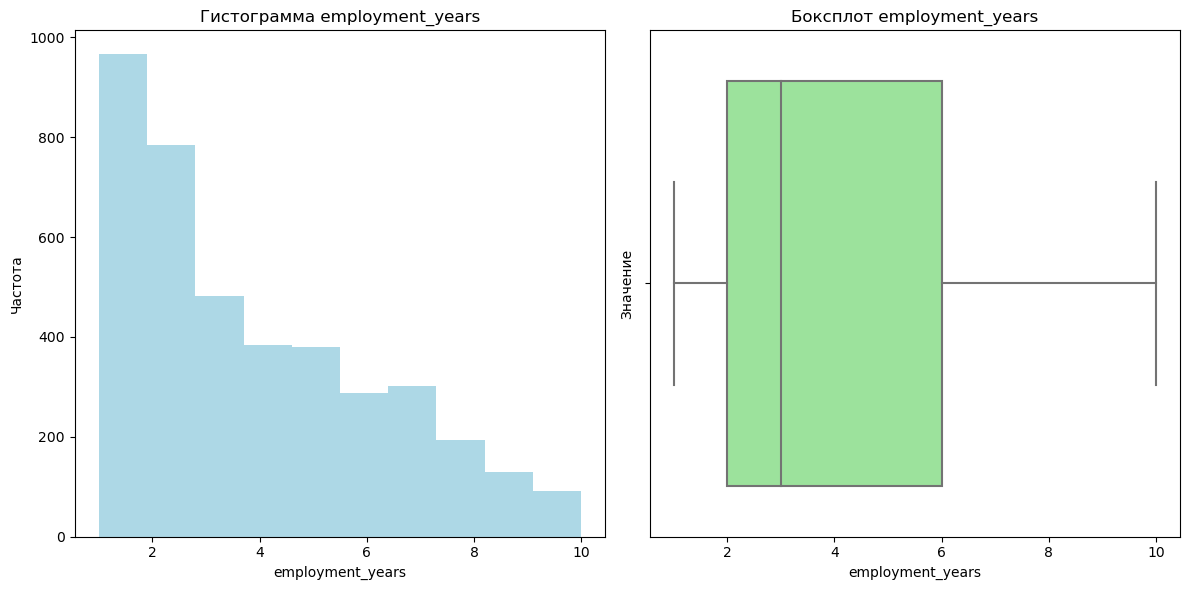

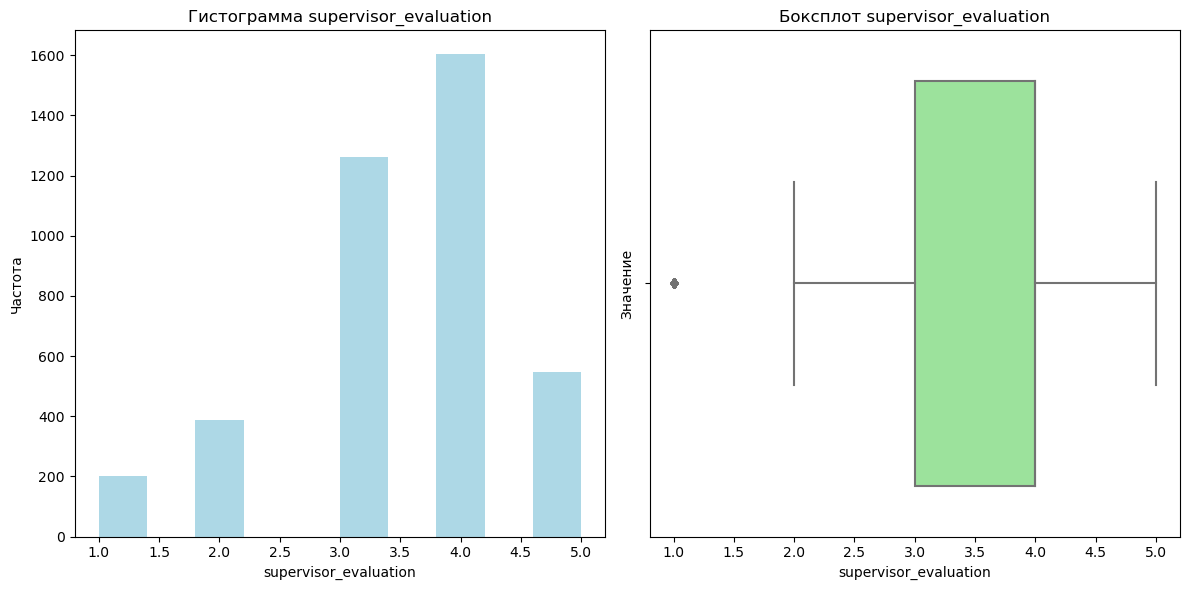

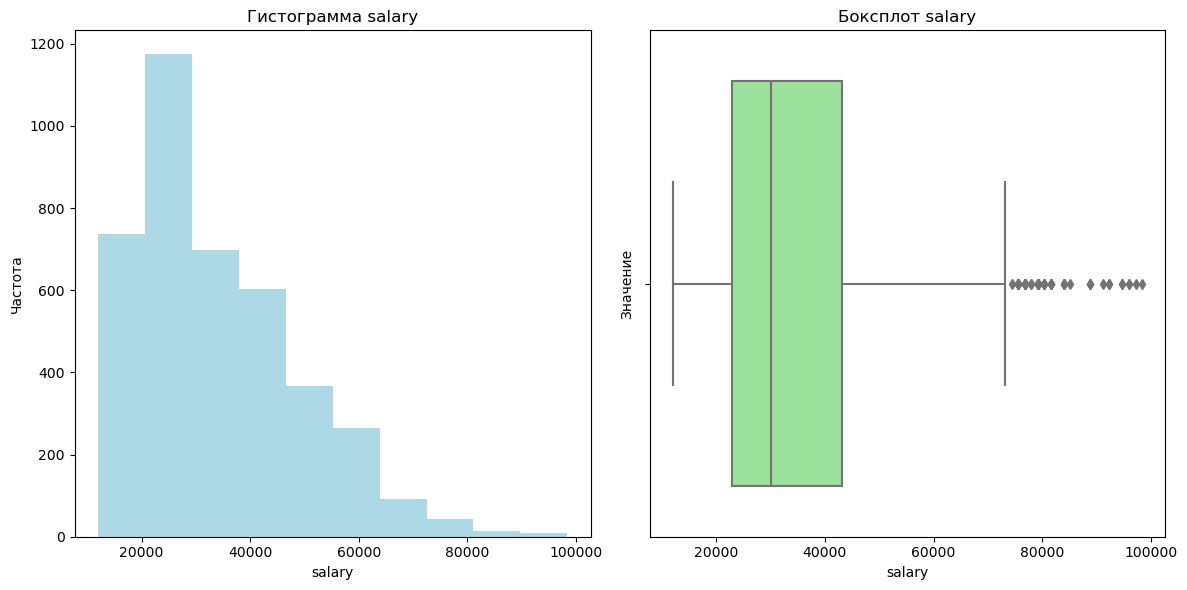

In [20]:
# вызовем функцию и построим графики
for feature in num_features:
    create_hist_and_boxplot(train_data, feature)

**Промежуточный вывод по полученным графикам**

В среднем сотрудники работают в компании в течение `3 лет`, есть "новички", которые работают меньше `2 лет` (их в компании значительное количество), есть и "старожилы", которые отдали компании до `10 лет` (их значительно меньше).

Средняя оценка руководителя составляет `около 4 баллов`, чуть меньшее количество сотрудников получают `от 3 до 3.5 баллов`, сотрудников, получивших `от 4.5 до 5 баллов` немного меньше, но еще меньше тех, кто получает совсем низкие оценки. Здесь имеются выбросы, удалять их не будем, т. к. скорей всего в компании есть сотрудники, которые плохо работают по мнению руководства. Если их не учесть, модель может недообучиться.

Большинство сотрудников получают `от 20 до 30 тыс.`, намного меньше людей, получающих `более 40 тыс.`, с высокими зарплатами (`до 100 тыс.`) сотрудников совсем мало. На графике виден большой хвост выбросов, вероятно, это единичные зарплаты сотрудников на высоких позициях.

Построим графики для оценки распределения **категориальных признаков**.

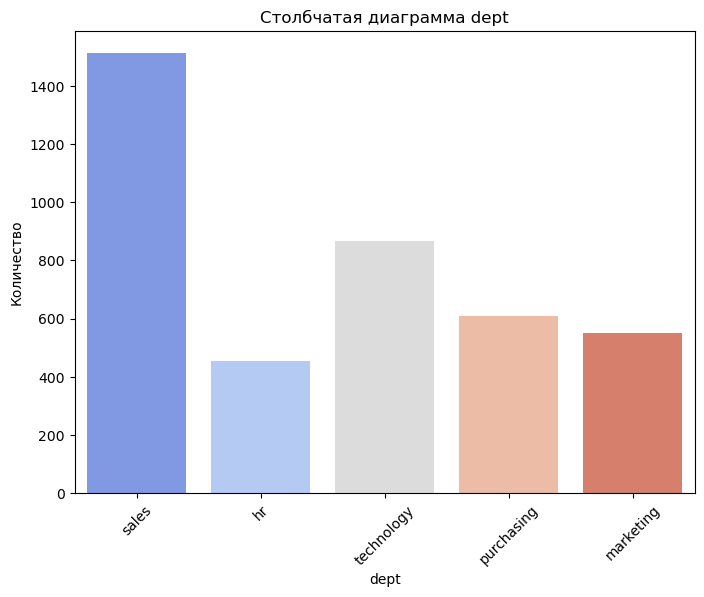

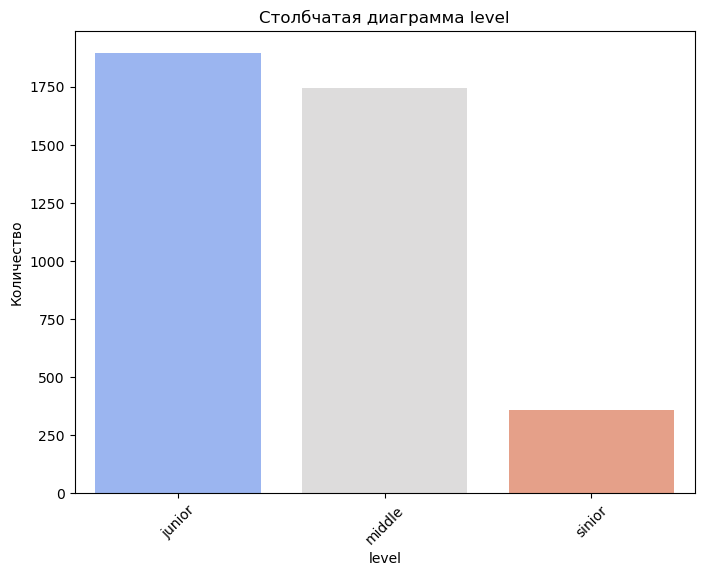

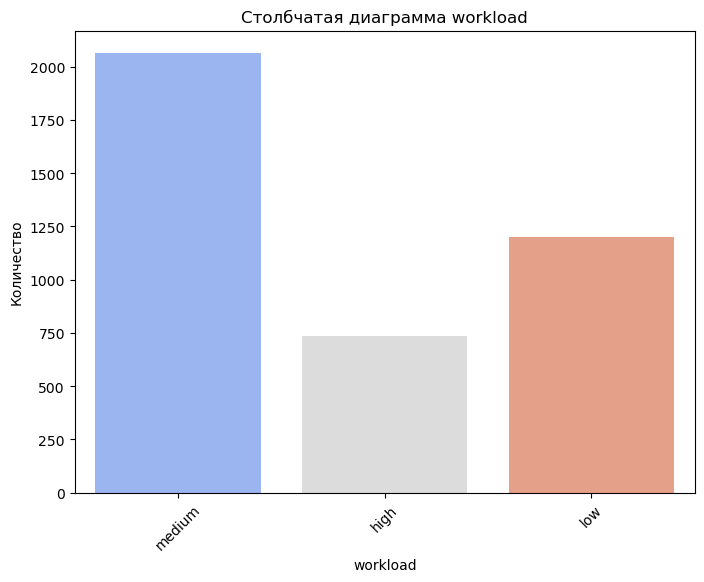

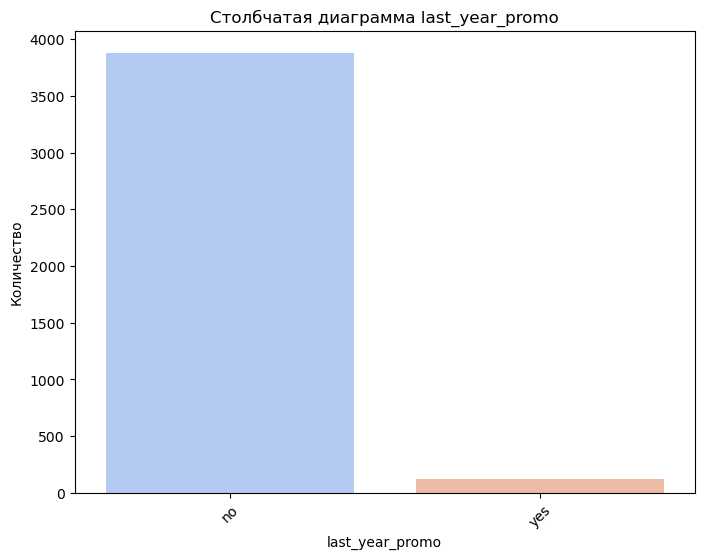

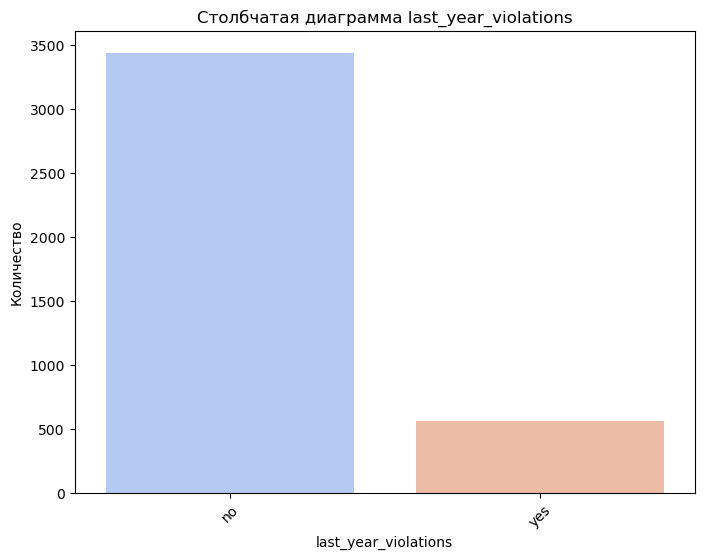

In [21]:
# вызовем функцию и построим графики
for feature in cat_features:
    create_barplot(train_data, feature)

Построим гистограмму распределения целевого признака `job_satisfaction_rate`.

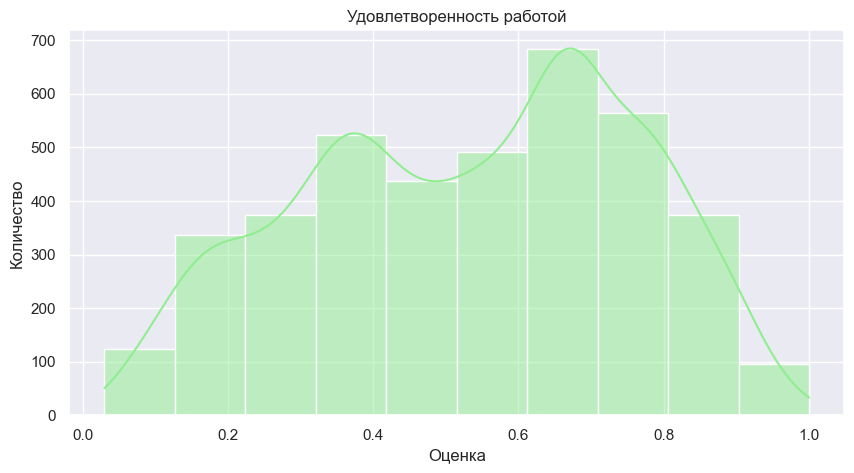

In [22]:
# построим гистограмму
plt.figure(figsize=(10, 5))
sns.set()
sns.histplot(train_data['job_satisfaction_rate'], kde=True, bins=10, color='lightgreen')
plt.title('Удовлетворенность работой')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show();

Здесь мы видим близкое к нормальному распределение, но наблюдается два пика, что говорит о том, что в данных представлены как сотрудники, которые удовлетворены своей работой, так и те, кому работа не нравится.

**Промежуточный вывод по полученным графикам**

Большиство сотрудников работает в отделе продаж, значительно меньше работает в технологическом отделе, в отделах закупок и маркетинга работает практически одинаковое небольшое количество сотрудников, и совсем немногочисленно представлен отдел кадров.

В компании работает значительное количество начинающих свою карьеру работников, чуть меньше опытных специалистов и совсем мало специалистов высокого уровня и руководителей.

В основном сотрудники компании имеют среднюю рабочую нагрузку, значительно меньше сотрудников с низкой и высокой нагрузкой.

Повышение за последний год получили незначительное количество сотрудников, остальным не посчастливилось.

Большиство сотрудников тщательно исполняют условия трудового договора, но есть незначительное количество нарушителей.

Целевой признак распределен практически нормально, с двумя пиками, которые говорят о присутствии в данных двух групп объектов.

Датафрейм `train_data` содержит все признаки, поэтому содержащиеся в нем данные разумно посмотреть в разрезе целевого признака (`job_satisfaction_rate`).

Для удобства построения графиков и избежания дублирования кода также напишем функции: будем строить **диаграммы рассеяния** для оценки зависимости количественных признаков от целевого и **ящики с усами** для оценки зависимости категориальных признаков от целевого.

In [23]:
# функция для построения диаграммы рассеяния
def create_scatterplot(data, target_feature):
    colors = train_data[target_feature]
    
    for feature in num_features:
        plt.scatter(data[feature], data[target_feature], c=colors, cmap='coolwarm')
        plt.xlabel(feature)
        plt.ylabel(target_feature)
        plt.title(f"Зависимость {target_feature} от {feature}")
        plt.colorbar(label=target_feature)
        plt.show()
        

# функция для построения ящиков с усами
def create_boxplot(data, target_feature):
    for feature in cat_features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=feature, y=target_feature, data=data, palette='coolwarm')
        plt.xlabel(feature)
        plt.ylabel(target_feature)
        plt.title(f"Зависимость {target_feature} от {feature}")
        plt.show()        

Построим графики **зависимости целевого признака** (удовлетворенность работой) **<u>от количественных</u> признаков**.

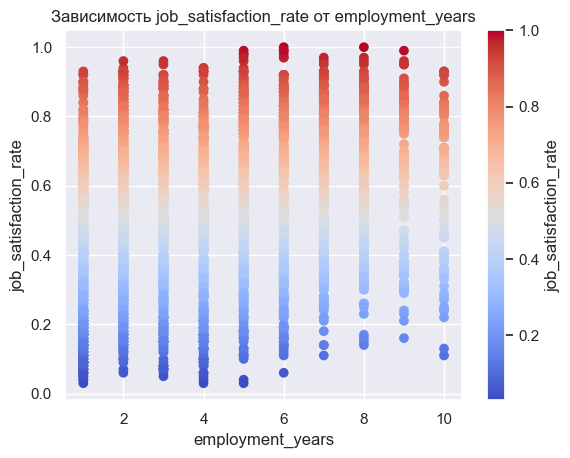

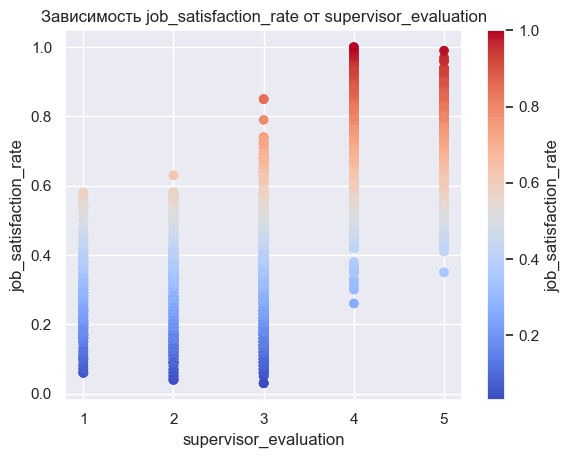

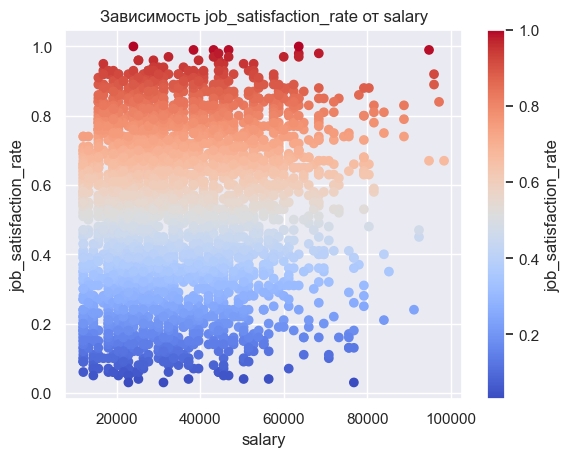

In [24]:
# вызовем функцию и построим графики
create_scatterplot(train_data, target_feature)

**Промежуточный вывод по полученным графикам**

Итак, есть незначительная зависимость степени удовлетворенности работой от длительности работы в компании: на графике видно, что сотрудники, отдавшие компании 6 и более лет, как будто бы более удовлетворены своей работой. Возможно, это так и есть, ведь иначе никто не мешает им уволиться.

Степень удовлетворенности работой очень связана с оценкой, полученной работником от руководителя: чем выше оценка, тем выше удовлетворенность.

От зарплаты как будто бы степень удовлетворенности работой не зависит: есть сотрудники с разной степенью удовлетворенности с разным уровнем зарплаты.

Построим графики **зависимости целевого признака** (удовлетворенность работой) **<u>от категориальных</u> признаков**.

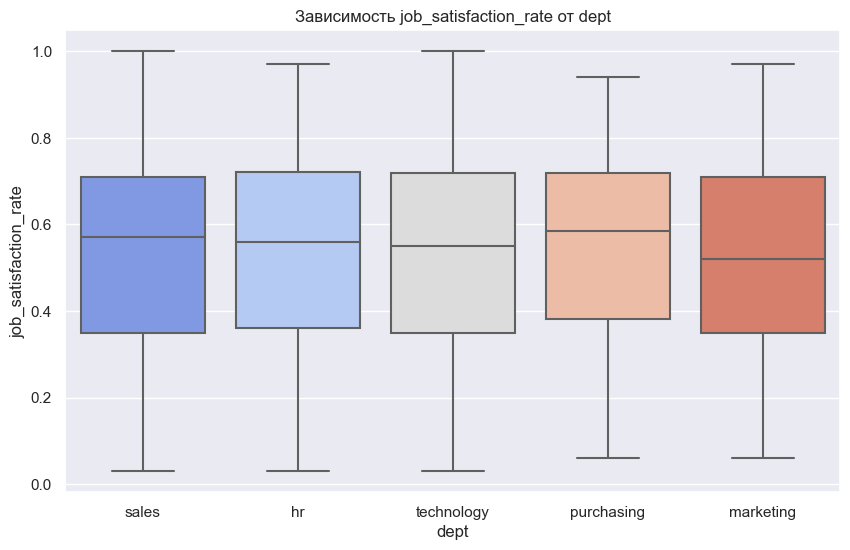

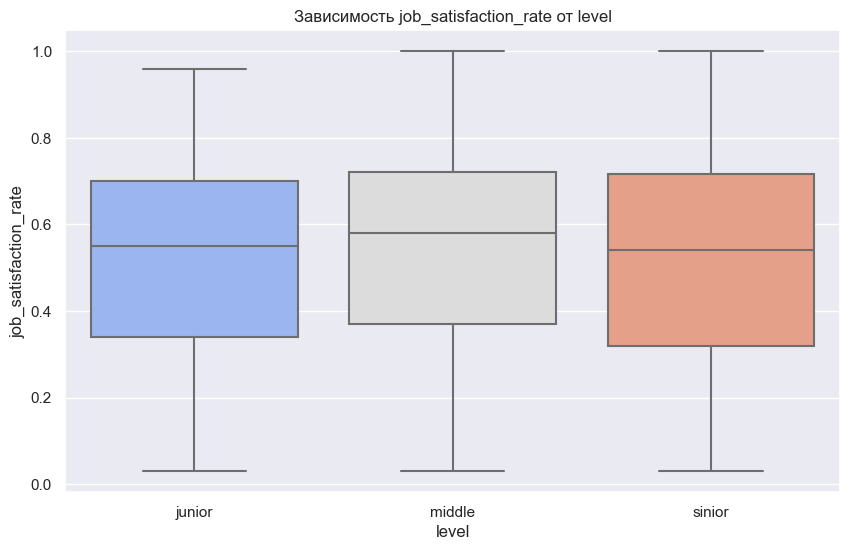

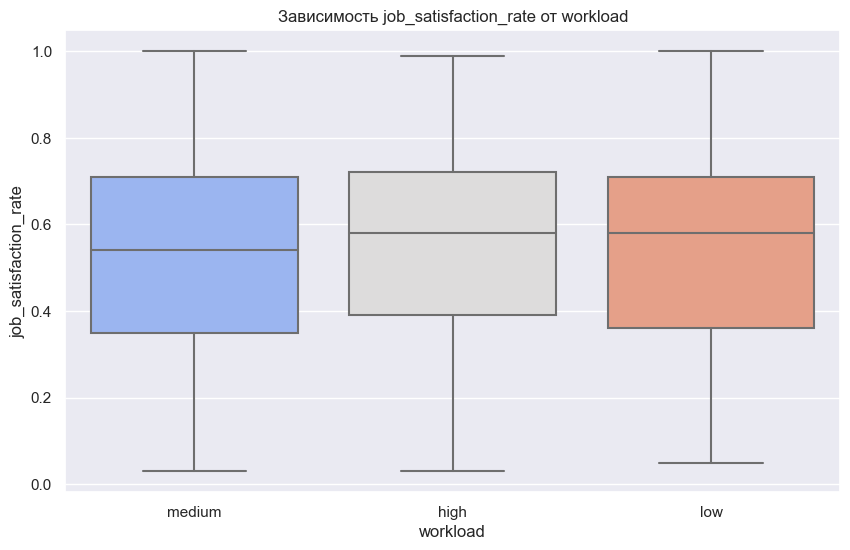

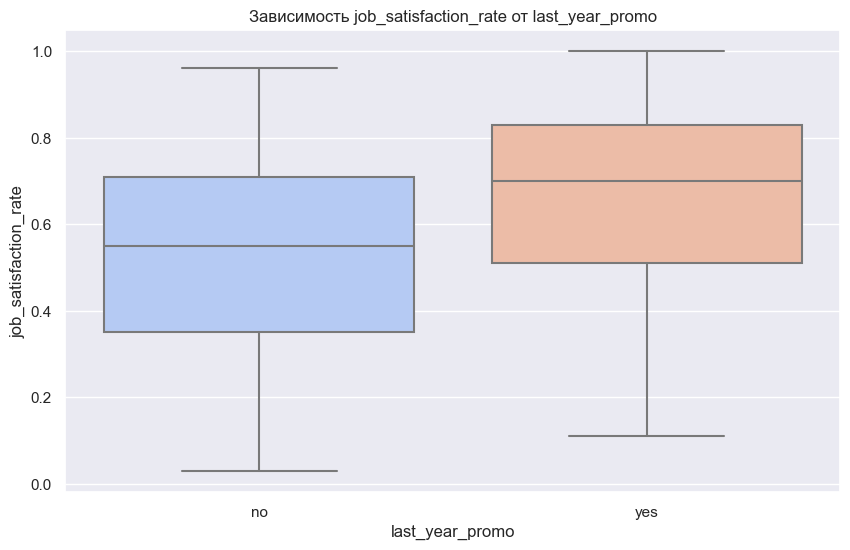

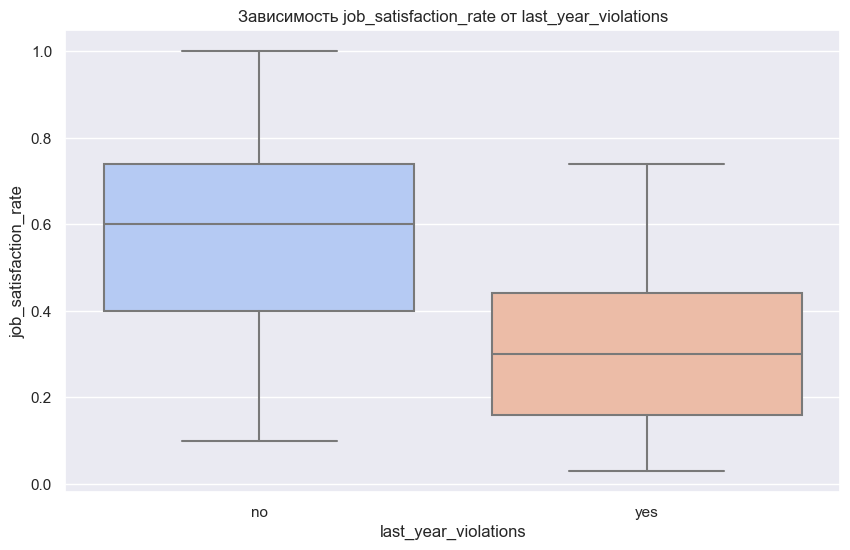

In [25]:
# вызовем функцию и построим графики
create_boxplot(train_data, target_feature)

**Промежуточный вывод по полученым графикам**

Итак, мы видим примерно одинаковый с небольшими отклонениями уровень удовлетворенности у сотрудников всех представленных отделов компании, аналогичная ситуация наблюдается, если оценивать сотрудников по степени квалификации и уровню рабочей наргузки.

Если рассматривать уровень удовлетворенности в связи с повышением в должности за последний год, то сотрудники, получившие повышение, более удовлетворены своей работой.

Также те, кто нарушал условия трудового договора менее довольны своей работой, чем те, кто условия договора не нарушал. Вероятно, нарушения и были связаны с тем, что что-то в условиях работы не устраивает, соответственно и сама работа не приносит большого удовлетворения.

**2.** Теперь рассмотрим тестовую выборку — датафрейм `test_data`.

Этот датафрейм не содержит целевого признака, поэтому просто посмотрим распределение признаков.

Построим графики для оценки распределения **количественных признаков**.

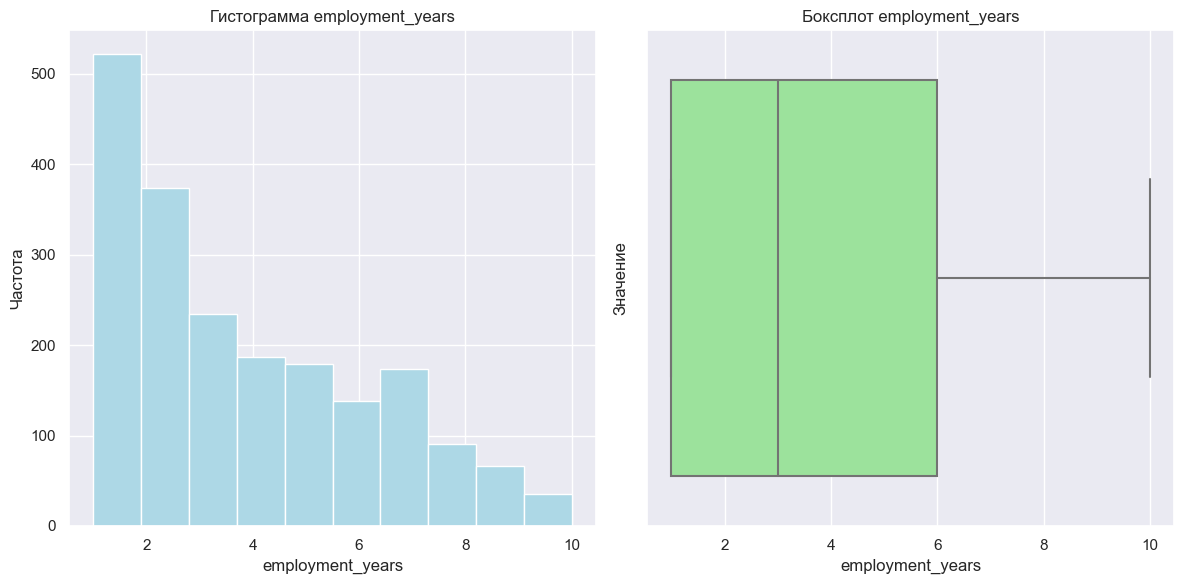

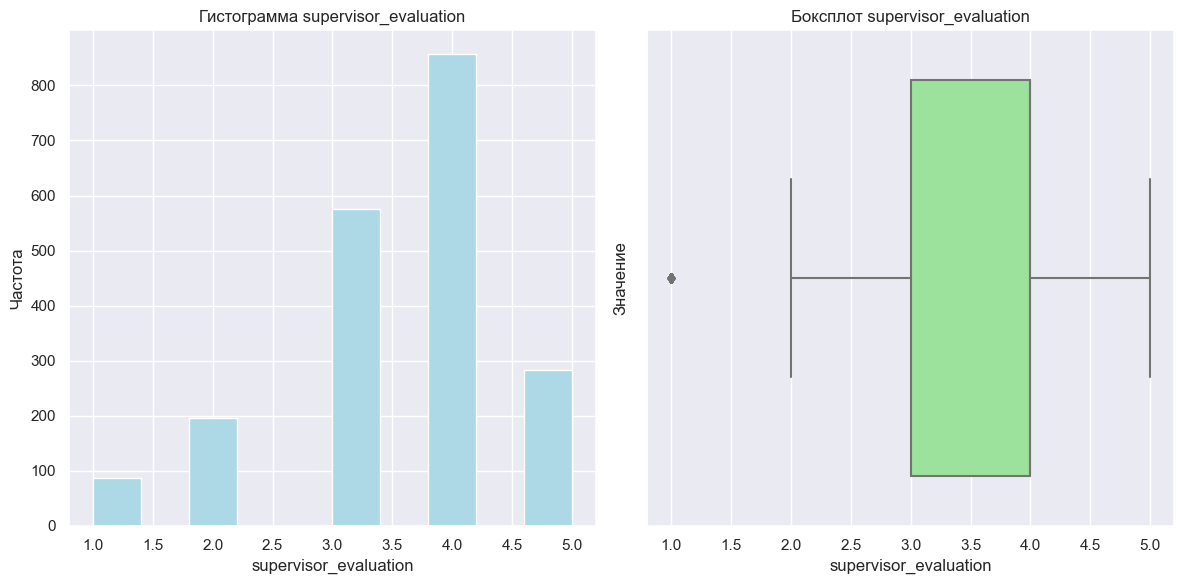

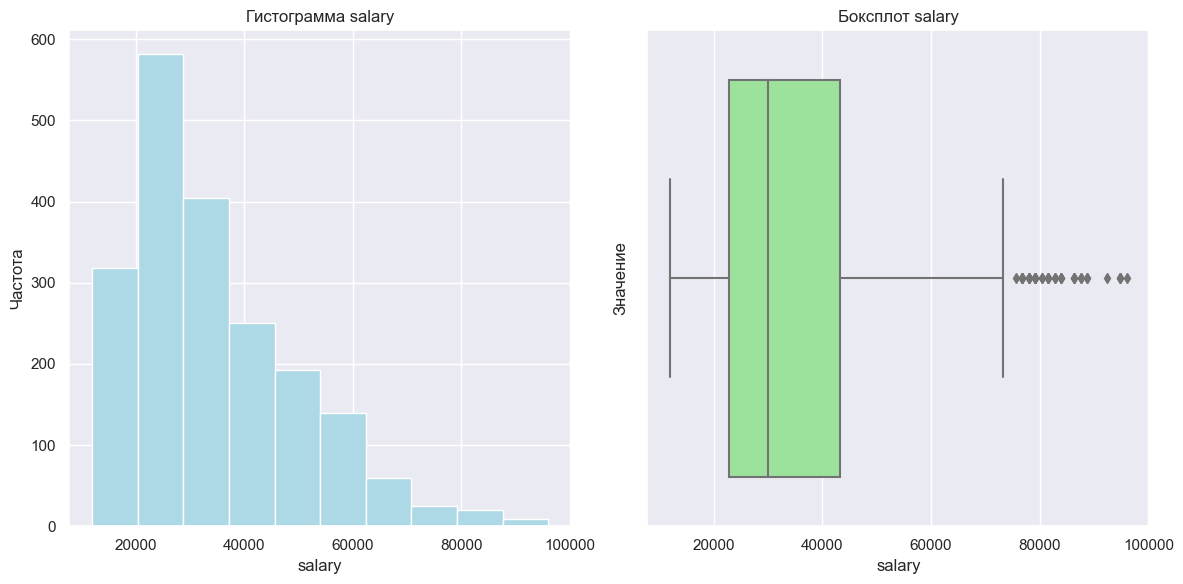

In [26]:
# вызовем функцию и построим графики
for feature in num_features:
    create_hist_and_boxplot(test_data, feature)

Построим графики для оценки распределения **категориальных признаков**.

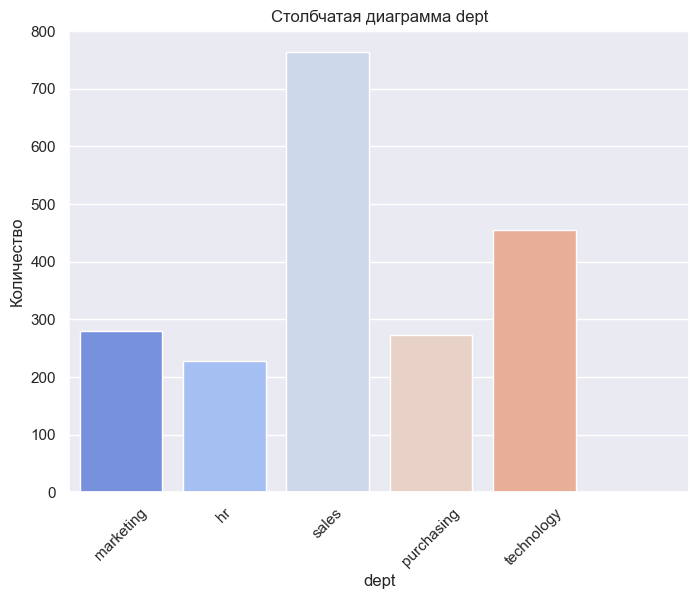

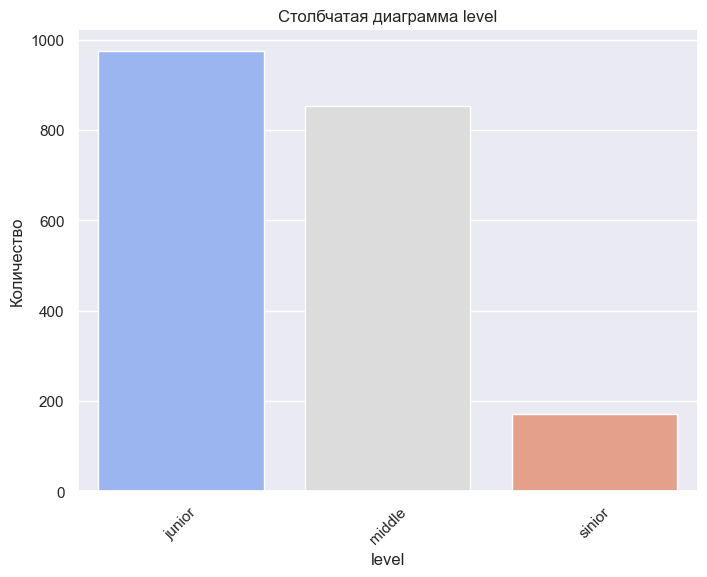

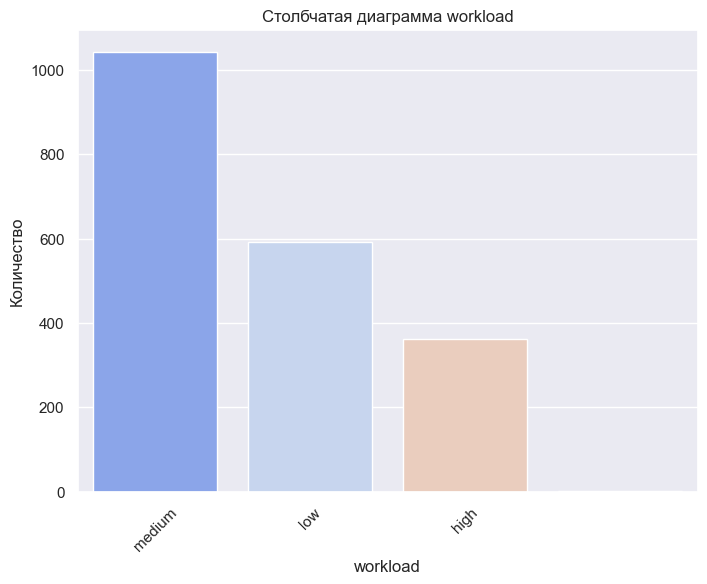

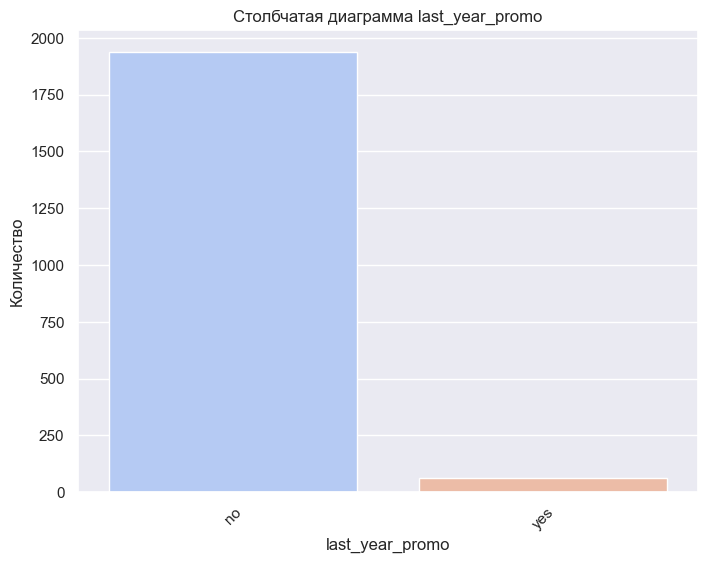

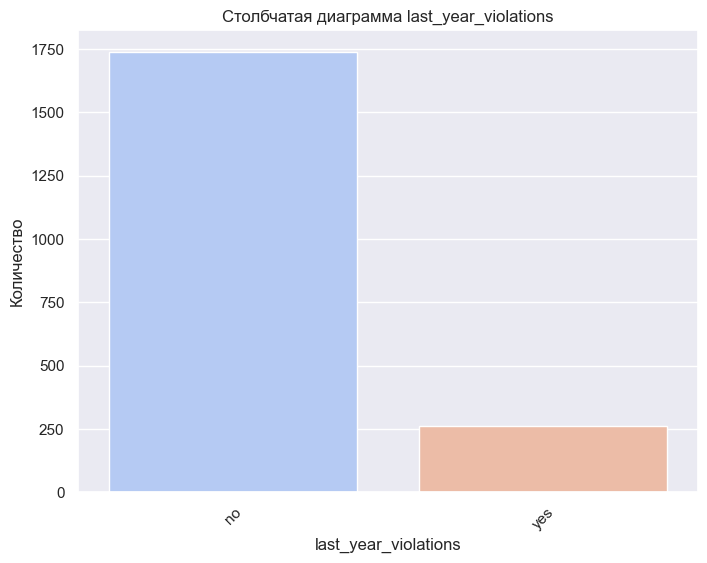

In [27]:
# вызовем функцию и построим графики
for feature in cat_features:
    create_barplot(test_data, feature)

**Промежуточный вывод по полученым графикам**

Распределение признаков в датафрейме `test_data` практически не отличается от распределения признаков в датафрейме `train_data`, описанном выше. Выводы по полученным графикам можно сделать аналогичные. Выбросы наблюдаются в тех же признаках, удалять выбросы не будем.

3. Рассмотрим распределение целевого признака тестовой выборки — датафрейм `target_data`.

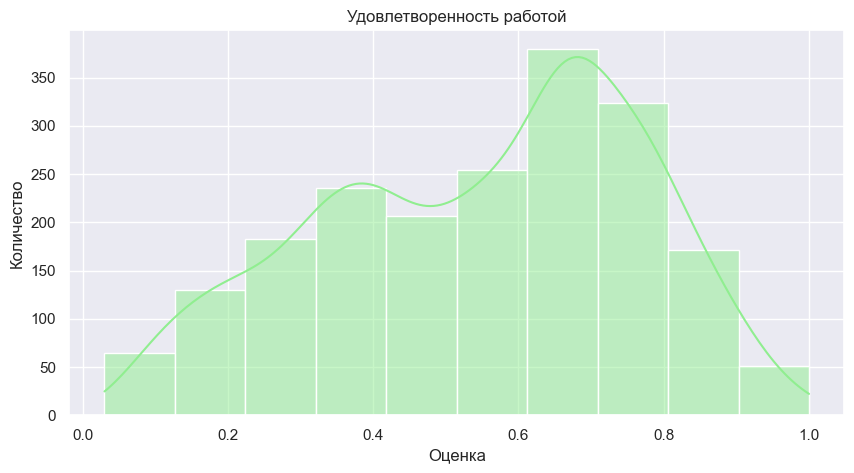

In [28]:
# построим гистограмму
plt.figure(figsize=(10, 5))
sns.set()
sns.histplot(target_data['job_satisfaction_rate'], kde=True, bins=10, color='lightgreen')
plt.title('Удовлетворенность работой')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show();

Здесь, также как и при построении аналогичного графика для целевого признака из датафрейма `train_data`, мы видим близкое к нормальному распределение с двумя пиками, что говорит о том, что в данных представлены как сотрудники, которые удовлетворены своей работой, так и те, которые не удовлетворены.

**<u>Общий вывод по исследовательскому анализу данных</u>**

В среднем сотрудники работают в компании в течение 3 лет, есть начинающие и те, кто работает порядка 10 лет. Сотрудники, отдавшие компании 6 и более лет, как будто бы более удовлетворены своей работой.

Средняя оценка руководителя составляет около 4 баллов, удовлетворенность работой связана с оценкой руководителя.

Большинство сотрудников получают от 20 до 30 тыс., намного меньше людей, получающих более 40 тыс., с высокими зарплатами (до 100 тыс.) сотрудников совсем мало. Уровень зарплаты не влияет на степень удовлетворенности. На графике виден большой хвост выбросов, вероятно, это единичные зарплаты сотрудников на высоких позициях.

Удалять выбросы в оценке руководителя и в уровне зарплаты не будем, поскольку модель может недообучиться, просто будем использовать скалер, который более устойчив к выбросам.

Большиство сотрудников работает в отделе продаж, значительно меньше работает в технологическом отделе, в отделах закупок и маркетинга работает практически одинаковое небольшое количество сотрудников, и совсем немногочисленно представлен отдел кадров.
Степень удовлетворенности работой во врех отделах примерно одинаковая.

В компании работает значительное количество начинающих свою карьеру работников, чуть меньше опытных специалистов и совсем мало специалистов высокого уровня и руководителей. Степерь удовлетворенности у сотрудников с разным уровнем квалификации примерно одинаковая.

В основном сотрудники компании имеют среднюю рабочую нагрузку, значительно меньше сотрудников с низкой и высокой нагрузкой. В данном случае степень удовлетворенности также не различается в зависимости от нагрузки.

Повышение за последний год получили незначительное количество сотрудников, их уровень удослетворенности работой значительно выше, чем у тех, кто повышение не получал.

Большиство сотрудников тщательно исполняют условия трудового договора, но есть незначительное количество нарушителей, нарушители менее удовлетворены своей работой.

Эти выводы верны для обоих датафреймов (`train_data` и `test_data`).

Распределение целевого признака из датафрейма `train_data` и из датафрейма `target_data` близко к нормальному с наличием двух пиков, что говорит о том, что в данных представлены две группы сотрудников: удовлетворенных своей работой, и не удовлетворенных ею.

### Подготовка данных

Прежде чем приступить к подготовке данных, построим матрицу Phik, которая широко используется для анализа корреляции между переменными в наборах данных. Это необходимо, чтобы обнаружить мультиколлинеарность в данных и, если она есть, устранить лишние признаки.

Рассмотрим матрицу корреляции для датафрейма `train_data`.

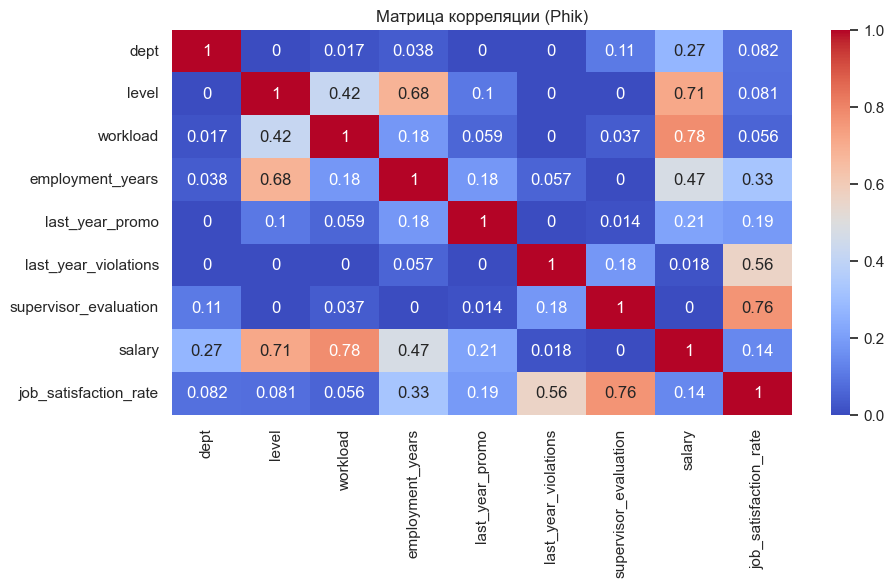

In [29]:
# создадим копию датафрейма без столбца идентификатора сотрудника для построения матрицы корреляции
train_data_copy = train_data.drop('id', axis=1)

# определим столбцы, которые имеют интервальные значения
interval_cols = ['employment_years', 'supervisor_evaluation',
                 'salary', 'job_satisfaction_rate']

# расчет коэффициентов корреляции Phik
correlation_matrix = phik.phik_matrix(train_data_copy, interval_cols=interval_cols)

# построение графика корреляции
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Матрица корреляции (Phik)")
plt.show();

Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от `0.9` до `0.95`. Здесь таких значений мы не наблюдаем.

Однако, можно заметить высокую корреляцию между признаками 'salary' и 'workload' — `0.78`, между целевым признаком 'job_satisfaction_rate' и  'supervisor_evaluation' — `0.76`, между 'salary' и 'level' — `0.71`, заметную корреляцию между 'employment_years' и 'level' — `0.68`, между целевым признаком 'job_satisfaction_rate' и 'last_year_violations' — `0.56`.

Итак, мультиколлинеарности между признаками не обнаружено, приступим к подготовке данных.

Для построения матрицы корреляции был удален признак `id`, поскольку он не несет смысловой нагрузки и добавляет в данные шум. Прежде чем делить датафрейм на обучающие признаки и целевую переменную, удалим этот признак из датафрейма, предварительно сохранив его копию с идентификаторами сотрудников.

In [30]:
train_data_with_id = train_data.copy()

Теперь можно безопасно удалить признак `id`.

In [31]:
train_data = train_data.drop('id', axis=1)

In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 281.4+ KB


Проверим наличия явных дубликатов в получившемся датафрейме.

In [33]:
train_data.duplicated().sum()

245

Итак, мы видим, что явных дубликатов после удаления идентификаторов сотрудников стало `245`, удалим их.

In [34]:
train_data = train_data.drop_duplicates()

In [35]:
# проверим, что получилось
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


Явные дубликаты удалены. Видим небольшое количество пропусков.

Теперь перейдем к разделению данных.

In [36]:
# выделим обучающие признаки и целевую переменную в обучающих данных
train_features = train_data.drop(['job_satisfaction_rate'], axis=1)
train_target = train_data['job_satisfaction_rate']

print(train_features.shape, train_target.shape)

(3755, 8) (3755,)


При изучении датафреймов с тестовыми данными мы заметили, что идентификаторы сотрудников располагаются в разном порядке, поэтому, во избежание несогласованности данных и возможных сложностей в дальнейшей работе, немного обработаем эти данные.

In [37]:
# объединим два исходных датафрейма по столбцу id
general_test_data = test_data.merge(target_data, on='id')
general_test_data.shape

(2000, 10)

Теперь для обеспечения согласованности тренировочных и тестовых данных, удалим столбец `id` в тестовых данных.

In [38]:
general_test_data = general_test_data.drop('id', axis=1)

In [39]:
general_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1998 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 156.2+ KB


Датафрейм `general_test_data` готов к работе.

Перейдем к разделению данных.

In [40]:
# теперь из полученного датафрейма выделим целевой признак
test_data = general_test_data.drop('job_satisfaction_rate', axis=1)
target_data = general_test_data['job_satisfaction_rate']

print(test_data.shape, target_data.shape)

(2000, 8) (2000,)


Подготовим признаки для кодирования.

In [41]:
# создадим списки с названиями признаков для кодировщиков
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']

Приступим к созданию пайплайна подготовки данных (по заданию именно на этом этапе мы должны заполнить пропуски).

In [42]:
# создаем пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
    )

# создаем пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'], 
            ['low', 'medium', 'high'], 
            ['no', 'yes'], 
            ['no', 'yes']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan
            )
    ),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
     ]
)

# создаем пайплайн для масштабирования числовых признаков
numeric_pipe = Pipeline(
    steps=[
        ('scaler', RobustScaler())
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', numeric_pipe, num_features)
     ],
     remainder='passthrough'
)

Подготовка данных выполнена. Пайплайн подготовки данных создан.

### Обучение моделей

В результате обучения нужно будет выбрать лучшую модель и проверить ее качество. Выбор требуется сделать на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). Напишем функцию для рассчета данной метрики. 

In [43]:
# функция вычисления SMAPE
def smape(y_test, pred): 
    metric = 100/len(y_test) * np.sum(2 * np.abs(pred - y_test) / (np.abs(y_test) + np.abs(pred)))
    return metric

Продолжим создание пайплайна: создание и обучение моделей. Будем использовать `DecisionTreeRegressor()`, `LinearRegression()` и `ElasticNet Regression()`.

In [44]:
# создание основного пайплайна
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [45]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 150),
        'models__max_features': range(2, 50),
        'models__min_samples_leaf': range(1, 5),
        'models__min_samples_split': range(2, 20)
    },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()] 
    },
    
    # словарь для модели ElasticNet Regression()
    {
        'models': [ElasticNet()],
        'models__alpha': [0.1, 0.5, 1.0],
        'models__l1_ratio': [0.2, 0.5, 0.8],
        'models__max_iter': [1000, 2000, 3000]
    }    
]

In [46]:
# создание scorer для метрики SMAPE
smape_scorer = make_scorer(smape, greater_is_better=False)

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=10,
    scoring=smape_scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search.fit(train_features, train_target)

result = pd.DataFrame(randomized_search.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head(10))    

# вывод лучшей модели и ее параметров
print('Лучшая модель и ее параметры:')
print(randomized_search.best_estimator_)
print('Метрика SMAPE лучшей модели на тренировочной выборке:', -randomized_search.best_score_)

# вычисление новой метрики качества модели
pred = randomized_search.predict(test_data)
smape_score = smape(target_data, pred)
print(f'Метрика SMAPE на тестовой выборке: {smape_score}')

,rank_test_score,param_models,mean_test_score,params
6,1,DecisionTreeRegressor(random_state=42),-15.197951,"{'models__min_samples_split': 2, 'models__min_samples_leaf': 3, 'models__max_features': 45, 'models__max_depth': 33, 'models': DecisionTreeRegressor(random_state=42)}"
0,2,DecisionTreeRegressor(random_state=42),-15.260711,"{'models__min_samples_split': 10, 'models__min_samples_leaf': 4, 'models__max_features': 15, 'models__max_depth': 37, 'models': DecisionTreeRegressor(random_state=42)}"
1,3,DecisionTreeRegressor(random_state=42),-15.270755,"{'models__min_samples_split': 7, 'models__min_samples_leaf': 4, 'models__max_features': 25, 'models__max_depth': 44, 'models': DecisionTreeRegressor(random_state=42)}"
9,4,DecisionTreeRegressor(random_state=42),-15.302564,"{'models__min_samples_split': 17, 'models__min_samples_leaf': 2, 'models__max_features': 37, 'models__max_depth': 41, 'models': DecisionTreeRegressor(random_state=42)}"
4,5,DecisionTreeRegressor(random_state=42),-15.317518,"{'models__min_samples_split': 16, 'models__min_samples_leaf': 3, 'models__max_features': 49, 'models__max_depth': 76, 'models': DecisionTreeRegressor(random_state=42)}"
8,6,DecisionTreeRegressor(random_state=42),-15.330689,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 2, 'models__max_features': 44, 'models__max_depth': 17, 'models': DecisionTreeRegressor(random_state=42)}"
3,7,DecisionTreeRegressor(random_state=42),-15.477307,"{'models__min_samples_split': 8, 'models__min_samples_leaf': 1, 'models__max_features': 43, 'models__max_depth': 107, 'models': DecisionTreeRegressor(random_state=42)}"
5,8,DecisionTreeRegressor(random_state=42),-15.507340,"{'models__min_samples_split': 19, 'models__min_samples_leaf': 4, 'models__max_features': 34, 'models__max_depth': 36, 'models': DecisionTreeRegressor(random_state=42)}"
2,9,DecisionTreeRegressor(random_state=42),-15.568509,"{'models__min_samples_split': 12, 'models__min_samples_leaf': 2, 'models__max_features': 10, 'models__max_depth': 40, 'models': DecisionTreeRegressor(random_state=42)}"
7,10,DecisionTreeRegressor(random_state=42),-15.690481,"{'models__min_samples_split': 12, 'models__min_samples_leaf': 2, 'models__max_features': 9, 'models__max_depth': 62, 'models': DecisionTreeRegressor(random_state=42)}"


Лучшая модель и ее параметры:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                             

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


**Вывод**

В результате выбрана лучшая модель — DecisionTreeRegressor() со следующими параметрами:

max_depth=33,
max_features=45,
min_samples_leaf=3,
random_state=42.

Метрика SMAPE лучшей модели на тренировочной выборке составляет с округлением `15.2`, что говорит хороших предсказательных способностях модели на обучающих данных. Метрика SMAPE на тестовой выборке составляет с округлением `13.4`, результат на тестовых данных даже лучше.

### Выводы

1. Были использованы разные модели для предсказания удовлетворенности сотрудников компании своей работой, а именно `DecisionTreeRegressor()`, `LinearRegression()` и `ElasticNet Regression()` (одна модель дерева решений и две линейные модели).

2. Из всех моделей, лучшей моделью в данном пайплайне была выбрана `DecisionTreeRegressor()` со следующими гиперпараметрами: `max_depth=33`, `max_features=45`, `min_samples_leaf=3`, `random_state=42`.

3. Метрика SMAPE для лучшей модели **на тренировочной выборке** составляет `15.2`. Это значение указывает на то, что модель достаточно хорошо справляется с предсказанием на тренировочных данных.

4. Метрика SMAPE **на тестовой выборке** составляет `13.4`. Это значение указывает на то, что модель показывает даже лучшую производительность на новых, ранее не знакомых ей данных.

Исходя из этих результатов, можно сказать, что выбранная модель `DecisionTreeRegressor()` в данном пайплайне достаточно хорошо справляется с предсказанием удовлетворенности своей работой сотрудников, как на тренировочных, так и на тестовых данных.

--------

Модель `DecisionTreeRegressor()` может быть эффективной в предсказании удовлетворенности сотрудников работой по нескольким причинам:

* Решающие деревья представляют собой гибкую модель, которая может адаптироваться к сложным и нелинейным зависимостям в данных. Уровни дерева позволяют модели делать различные разбиения на основе признаков, которые могут быть важными для предсказания удовлетворенности сотрудников.

* `DecisionTreeRegressor()` способна обрабатывать нелинейные взаимодействия между признаками. Например, модель может уловить, что определенная комбинация признаков (например, рабочая нагрузка и зарплата) может сильно влиять на удовлетворенность сотрудников, что может быть сложнее для линейных моделей.

* Решающие деревья могут быть более устойчивы к плохо структурированным или зашумленным данным. Они могут игнорировать выбросы или несущественные признаки, что позволяет лучше анализировать и делать предсказания.

## Задача вторая: предсказание увольнения сотрудника из компании

**<u>Описание данных</u>**

Для работы предоставлено **три датасета**: 
* `train_quit.csv` — тренировочная выборка
* `test_features.csv` — входные признаки тестовой выборки
* `test_target_quit.csv` — целевой признак тестовой выборки

**Признаковое пространство** для исследования:

Признаковое описание аналогично таковому первой задачи. См.выше.

Целевой признак отличается: это `quit` — увольнение сотрудника из компании.

**<u>План работы</u>**

1. **Загрузка данных**

Открыть предоставленные файлы, убедиться, что данные в таблицах соответствуют описанию.

2. **Предобработка данных**

Изучить данные и сделать выводы. При необходимости выполнить предобработку. Если есть пропуски, заполнить их в пайплайне.

3. **Исследовательский анализ данных**

3.1. Проведите исследовательский анализ данных.

3.2. Составить портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Требуется проверить это утверждение: для этого необходимо визуализировать и сравнить распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Нужно использовать данные с обоими целевыми признаками тестовой выборки.

4. **Добавление нового входного признака**

Допустим, `job_satisfaction_rate` и `quit` действительно связаны и получено необходимое значение метрики в первой задаче. Тогда нужно добавить `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

5. **Подготовка данных**

Выполнить подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывать особенности признаков и моделей и использовать как минимум два кодировщика.

6. **Обучение моделей**

Обучить как минимум три модели. Как минимум для двух из них подобрать гиперпараметры. Проверить качество лучшей модели.
Метрика оценки качества в этой задаче — `ROC-AUC`. Критерий успеха: `ROC-AUC ≥ 0.91` на тестовой выборке.

7. **Выводы**

Сделать выводы о том, какая модель справилась лучше и почему.

### Загрузка данных

In [47]:
# сохраним датафреймы в переменные
train_data = pd.read_csv('datasets/train_quit.csv')

# признаки те же, что и в первой задаче, но поскольку датафрейм изменялся, перезапишем переменную
test_data = pd.read_csv('datasets/test_features.csv')
target_data = pd.read_csv('datasets/test_target_quit.csv')

In [48]:
# просмотрим первые строки первого датафрейма
train_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [49]:
# просмотрим общую информацию о датафрейме
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Датафрейм `train_data` состоит из `4000` строк и `10` столбцов, пропусков нет, данные представлены целочисленными и строковыми значениями.

In [50]:
# просмотрим первые строки второго датафрейма
test_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [51]:
# просмотрим общую информацию о датафрейме
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Датафрейм `test_data` состоит из `2000` строк и `9` столбцов, есть незначительное количество пропусков, данные представлены целочисленными и строковыми значениями.

In [52]:
# просмотрим первые строки третьего датафрейма
target_data.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [53]:
# просмотрим общую информацию о датафрейме
target_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Датафрейм `target_data` состоит из `2000` строк и `2` столбцов, пропусков нет, данные представлены целочисленными и вещественными значениями.

**Вывод**

Для работы предоставлено три датафрейма: тренирочая выборка, входные признаки тестовой выборки и целевой признак тестовой выборки. Все типы данных соотвествуют тем, которые даны в описании к названиям признаков. В датафрейме `test_data` (входные признаки тестовой выборки) имеется незначительное количество пропусков.

### Предобработка данных

Как было отмечено выше, в датафрейме`test_data` есть пропуски, удалять или каким-то образом обрабатывать их будем на следующем этапе.
А пока выполним поиск и обработку дубликатов и других аномалий. Для начала проверим наличие уникальных строковых значений в предоставленных датафреймах.

In [54]:
# рассмотрим датафрейм train_data
unique_values_dept = train_data['dept'].unique()
unique_values_level = train_data['level'].unique()
unique_values_workload = train_data['workload'].unique()
unique_values_last_year_promo = train_data['last_year_promo'].unique()
unique_values_last_year_violations = train_data['last_year_violations'].unique()
unique_values_quit = train_data['quit'].unique()

print("Датафрейм 'train_data'")
print("------------------------------")
print("Уникальные значения в столбце 'dept':")
print(unique_values_dept)
print("------------------------------")
print("Уникальные значения в столбце 'level':")
print(unique_values_level)
print("------------------------------")
print("Уникальные значения в столбце 'workload':")
print(unique_values_workload)
print("------------------------------")
print("Уникальные значения в столбце 'last_year_promo':")
print(unique_values_last_year_promo)
print("------------------------------")
print("Уникальные значения в столбце 'last_year_violations':")
print(unique_values_last_year_violations)
print("------------------------------")
print("Уникальные значения в столбце 'quit':")
print(unique_values_quit)

Датафрейм 'train_data'
------------------------------
Уникальные значения в столбце 'dept':
['sales' 'purchasing' 'marketing' 'technology' 'hr']
------------------------------
Уникальные значения в столбце 'level':
['middle' 'junior' 'sinior']
------------------------------
Уникальные значения в столбце 'workload':
['high' 'medium' 'low']
------------------------------
Уникальные значения в столбце 'last_year_promo':
['no' 'yes']
------------------------------
Уникальные значения в столбце 'last_year_violations':
['no' 'yes']
------------------------------
Уникальные значения в столбце 'quit':
['no' 'yes']


В этом датафрейме ничего подозрительного нет.

Датафрейм `test_data` проверялся при выполнении первой задачи, но поскольку мы его уже модифицировали и для выполнения этой задачи взяли исходную версию, обработаем пустые строки в пайплайне.

Проверим, есть ли в датафреймах явные дубликаты.

In [55]:
print(train_data.duplicated().sum())
print(test_data.duplicated().sum())
print(target_data.duplicated().sum())

0
0
0


Явных дубликатов не обнаружено.

**Вывод**

В датафремах нет явных дубликатов. Обнаруженные пустые строки и пропуски будут обработаны в пайплайне в соответствии с заданием.

### Исследовательский анализ данных

#### Анализ данных

Для начала просмотрим сводную информацию о датафреймах.

Поскольку датафрейм `test_data` уже был подробно рассмотрен при выполнении первой задачи, заново исследовать его нет смысла. Все наблюдания и выводы можно посмотреть выше.

In [56]:
# просмотрим статистику датафрейма train_data
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


В датафрейме `target_data` нет числовых значений, распределение данных в нем посмотрим графически.

Проведем графический анализ датафреймов `train_data` и `target_data`.

**1.** Начнем с тренировочной выборки — датафрейм `train_data`.

In [57]:
# определим количественные, категориальные признаки и целевую переменную
num_features = ['employment_years', 'supervisor_evaluation', 'salary']
cat_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
target_feature = 'quit'

Будем строить **гистограммы и ящики с усами** для количественных признаков и **столбчатые диаграммы** для категориальных признаков, используя функции, написанные при выполнении первой задачи.

Построим графики для оценки распределения **количественных признаков**.

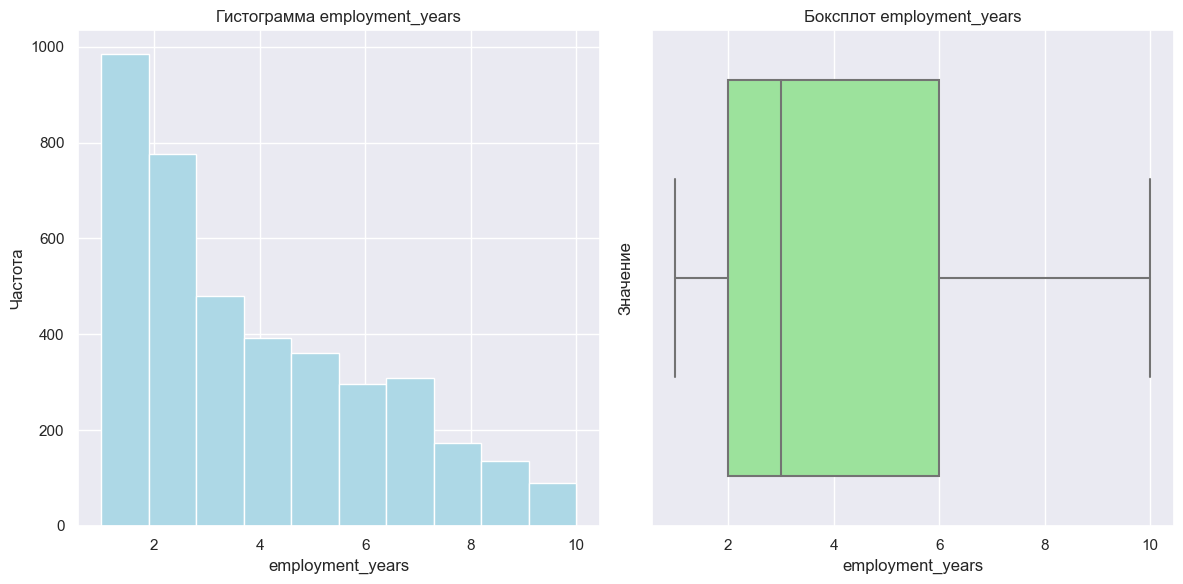

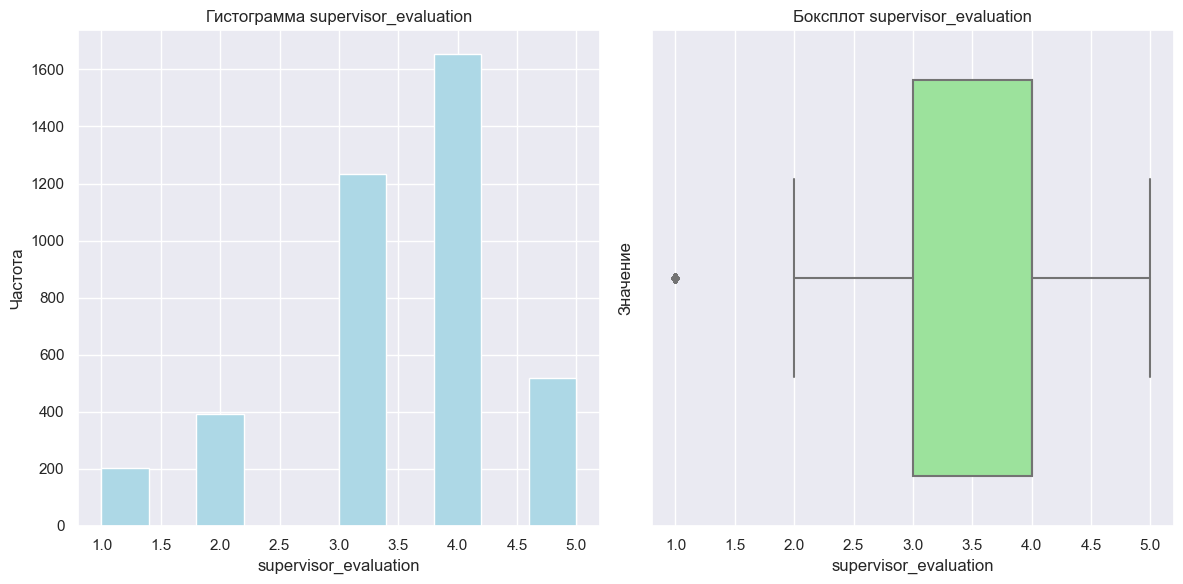

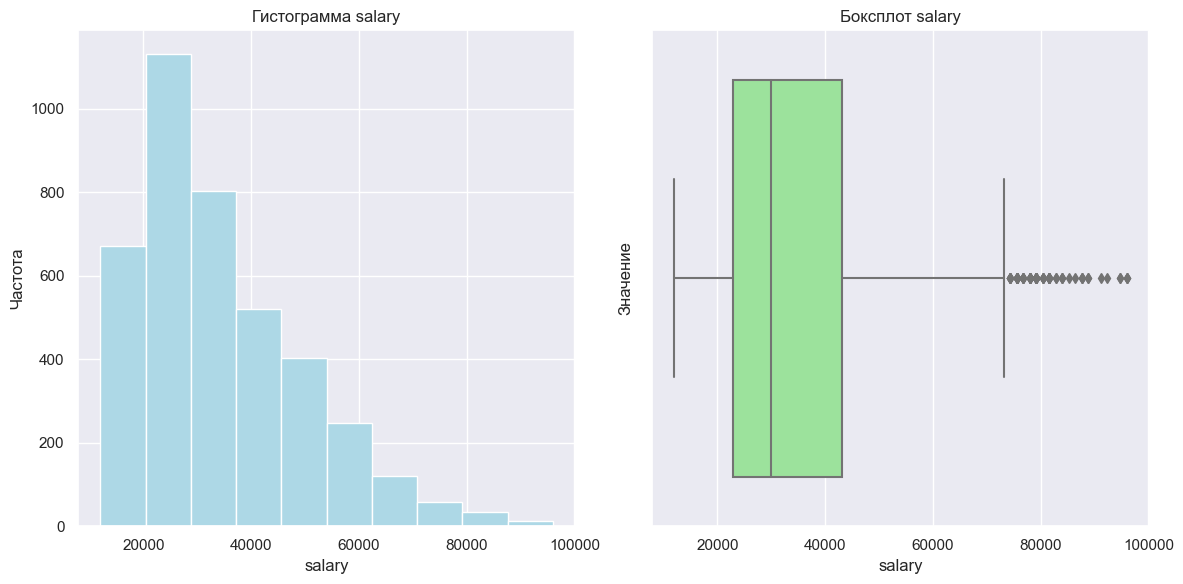

In [58]:
# вызовем функцию и построим графики
for feature in num_features:
    create_hist_and_boxplot(train_data, feature)

**Промежуточный вывод по полученным графикам**

В среднем сотрудники работают в компании в течение `3—4 года`, есть "новички", которые работают меньше `2 лет` (их в компании значительное количество), есть и "старожилы", которые отдали компании до `10 лет` (их значительно меньше).

Средняя оценка руководителя составляет `около 4 баллов`, чуть меньшее количество сотрудников получают `от 3 до 3.5 баллов`, сотрудников, получивших `от 4.5 до 5 баллов` немного меньше, но еще меньше тех, кто получает совсем низкие оценки. Здесь имеются выбросы, удалять их не будем, т. к. скорей всего в компании есть сотрудники, которые плохо работают по мнению руководства. Если их не учесть, модель может недообучиться.

Большинство сотрудников получают `от 20 до 40 тыс.`, намного меньше людей, получающих `более 40 тыс.`, с высокими зарплатами (`до 100 тыс.`) сотрудников совсем мало. На графике виден большой хвост выбросов, вероятно, это единичные зарплаты сотрудников на высоких позициях.

Построим графики для оценки распределения **категориальных признаков**.

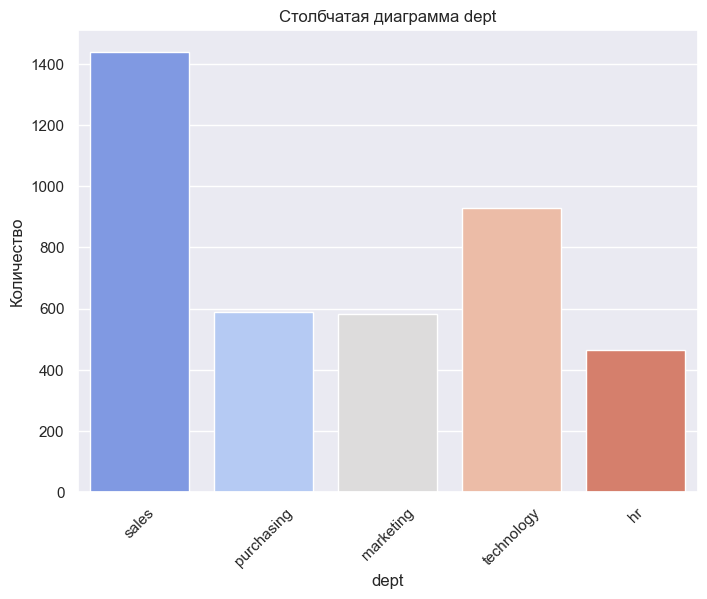

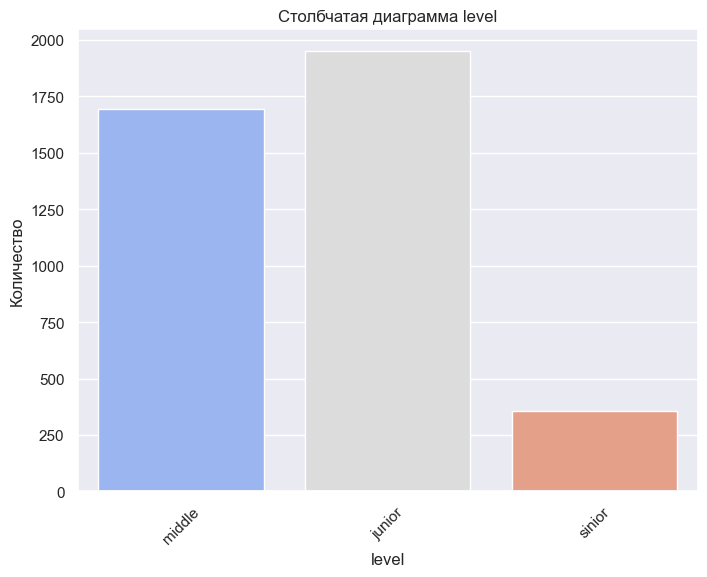

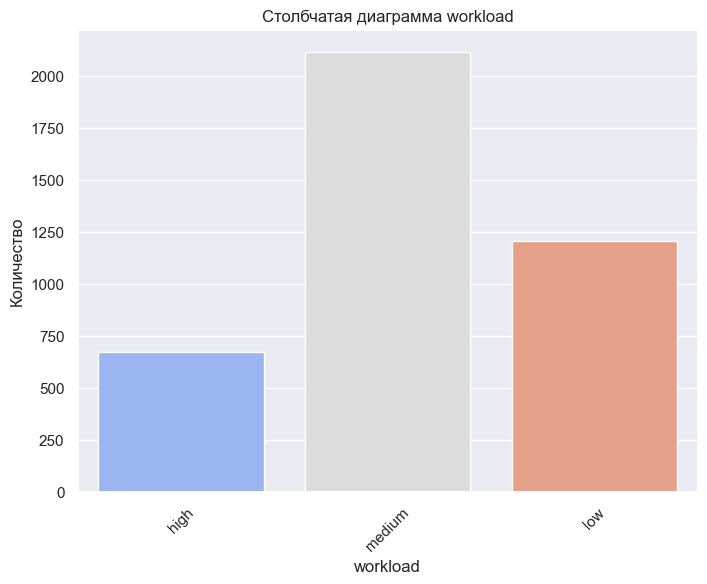

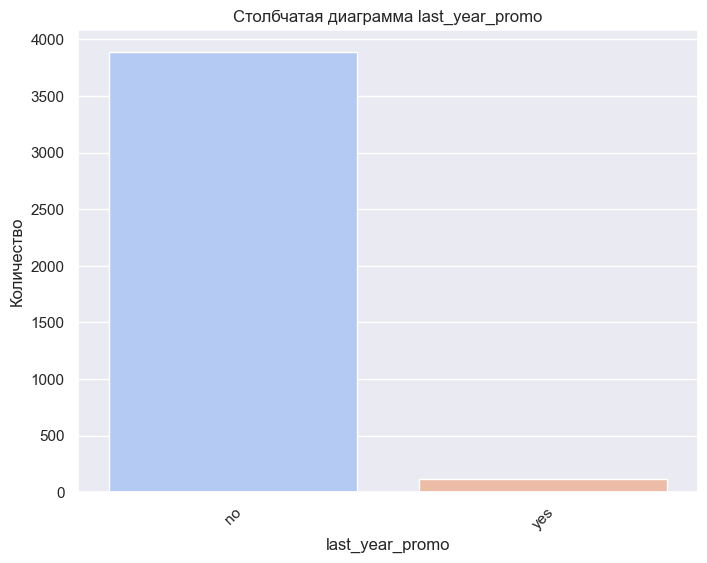

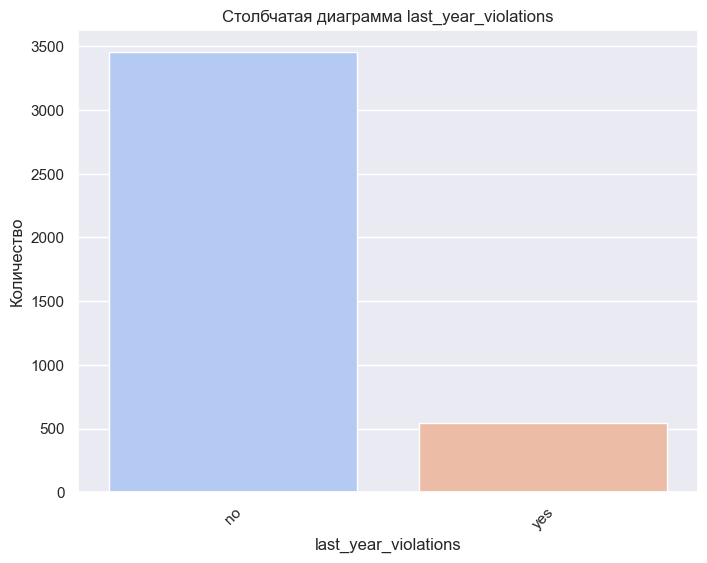

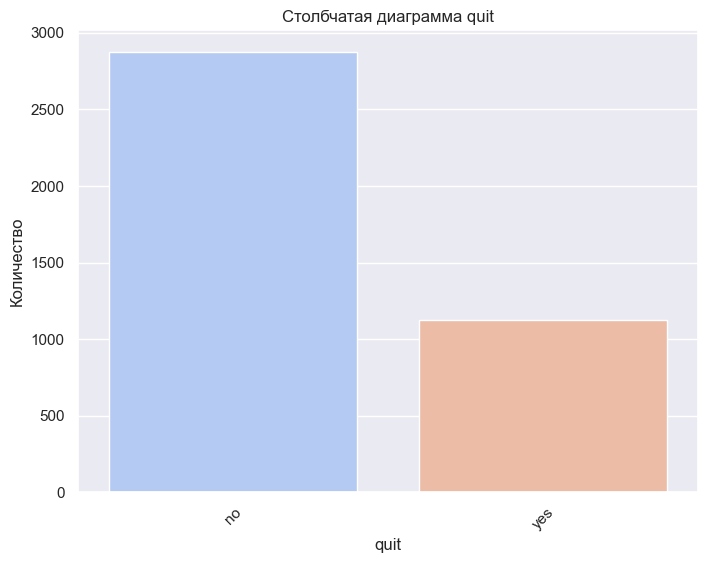

In [59]:
# вызовем функцию и построим графики
for feature in cat_features:
    create_barplot(train_data, feature)

**Промежуточный вывод по полученным графикам**

Большиство сотрудников работает в отделе продаж, значительно меньше работает в технологическом отделе, в отделах закупок и маркетинга работает одинаково небольшое количество сотрудников, и совсем немногочисленно представлен отдел кадров.

В компании работает значительное количество начинающих свою карьеру работников, чуть меньше опытных специалистов и совсем мало специалистов высокого уровня и руководителей.

В основном сотрудники компании имеют среднюю рабочую нагрузку, значительно меньше сотрудников с низкой и высокой нагрузкой.

Повышение за последний год получили незначительное количество сотрудников, остальные не получили повышения.

Большиство сотрудников тщательно исполняют условия трудового договора, но есть незначительное количество нарушителей.

Столбчатая диаграмма целевого признака (увольнение сотрудника из компании) говорит о том, что количество уволившихся к оставшимся на службе сотружникам имеет отношение примерно `1 : 2.5`, т.е. увольнения происходят часто.

**2.** Рассмотрим распределение целевого признака тестовой выборки — датафрейм `target_data`.

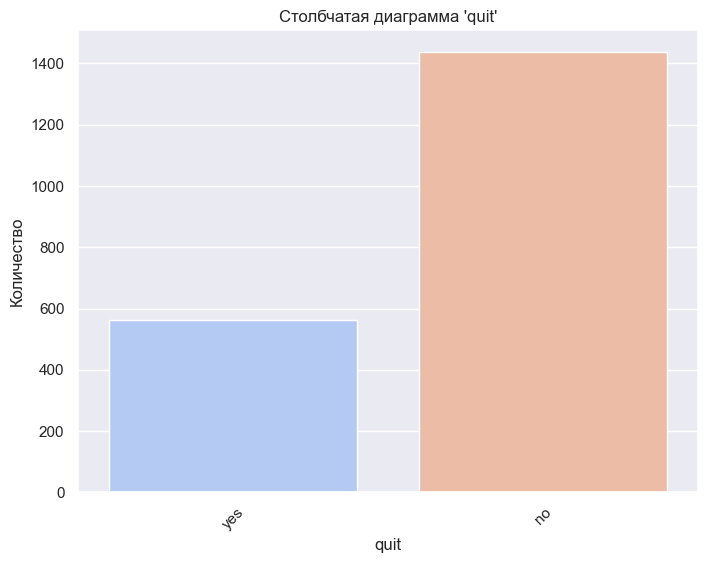

In [60]:
plt.figure(figsize=(8, 6))
sns.countplot(x=target_data['quit'], palette='coolwarm')
plt.xlabel('quit')
plt.ylabel('Количество')
plt.title(f"Столбчатая диаграмма 'quit'")
plt.xticks(rotation=45)
plt.show()

Итак, по этому графику видно, что целевой признак также представлен данными с достаточно высоким уровнем увольнений: количество тех, кто уволился, чуть меньше чем в 2 раза меньше количества тех, кто продолжает работать.

**<u>Общий вывод по исследовательскому анализу данных</u>**

В среднем сотрудники работают в компании в течение `3—4 года`, есть "новички", которые работают меньше `2 лет` (их в компании значительное количество), есть и "старожилы", которые отдали компании до `10 лет` (их значительно меньше).

Средняя оценка руководителя составляет `около 4 баллов`, чуть меньшее количество сотрудников получают `от 3 до 3.5 баллов`, сотрудников, получивших `от 4.5 до 5 баллов` немного меньше, но еще меньше тех, кто получает совсем низкие оценки. Здесь имеются выбросы, удалять их не будем, т. к. скорей всего в компании есть сотрудники, которые плохо работают по мнению руководства. Если их не учесть, модель может недообучиться.

Большинство сотрудников получают `от 20 до 40 тыс.`, намного меньше людей, получающих `более 40 тыс.`, с высокими зарплатами (`до 100 тыс.`) сотрудников совсем мало. На графике виден большой хвост выбросов, вероятно, это единичные зарплаты сотрудников на высоких позициях.

Большиство сотрудников работает в отделе продаж, значительно меньше работает в технологическом отделе, в отделах закупок и маркетинга работает одинаково небольшое количество сотрудников, и совсем немногочисленно представлен отдел кадров.

В компании работает значительное количество начинающих свою карьеру работников, чуть меньше опытных специалистов и совсем мало специалистов высокого уровня и руководителей.

В основном сотрудники компании имеют среднюю рабочую нагрузку, значительно меньше сотрудников с низкой и высокой нагрузкой.

Повышение за последний год получили незначительное количество сотрудников, остальные не получили повышения.

Большиство сотрудников тщательно исполняют условия трудового договора, но есть незначительное количество нарушителей.

Столбчатая диаграмма <u>целевого признака</u> (увольнение сотрудника из компании) говорит о том, что количество уволившихся к оставшимся в компании сотрудников имеет отношение примерно `1 : 2.5`, т.е. увольнения происходят часто.

Целевой признак в датафрейме `target_data` представлен данными с достаточно высоким уровнем увольнений: количество тех, кто уволился, чуть меньше чем в 2 раза меньше количества тех, кто продолжает работать.

#### Портрет «уволившегося сотрудника»

Для того, чтобы составить портрет уволившегося сотрудника, разделим тренировочный датафрейм `train_data` на два датафрейма: в одном соберем сотрудников, которые остались на работе (`df_stay`), во втором — тех, что уволился (`df_quit`).

In [61]:
# датафрейм с сотрудниками, которые остались
df_stay = train_data.query("quit == 'no'")
df_stay.shape

(2872, 10)

In [62]:
# датафрейм с сотрудниками, которые уволились
df_quit = train_data.query("quit == 'yes'")
df_quit.shape

(1128, 10)

Для начала просмотрим сводную информацию о датафреймах.

In [63]:
df_stay.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2872.0,555066.499652,260962.518935,100469.0,329560.5,548319.5,793533.5,999915.0
employment_years,2872.0,4.430710,2.544635,1.0,2.0,4.0,6.0,10.0
supervisor_evaluation,2872.0,3.643106,0.965295,1.0,3.0,4.0,4.0,5.0
salary,2872.0,37702.228412,15218.977339,12000.0,25200.0,34800.0,46800.0,96000.0


In [64]:
df_quit.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1128.0,544544.457447,258059.498361,100222.0,325073.0,545003.5,756296.0,999158.0
employment_years,1128.0,1.844858,1.274920,1.0,1.0,1.0,2.0,10.0
supervisor_evaluation,1128.0,3.046099,0.973291,1.0,3.0,3.0,4.0,5.0
salary,1128.0,23885.106383,9351.599505,12000.0,16800.0,22800.0,27600.0,79200.0


Теперь напишем функции для построения графиков.

In [65]:
# функция для построения гистограмм
def plot_histograms(df1, df2, column):
    plt.figure(figsize=(10, 6))

    # гистограмма для оставшихся
    plt.subplot(1, 2, 1)
    plt.hist(df1[column], bins=10, alpha=0.5, color="lightblue")
    plt.title("Оставшиеся сотрудники")
    plt.xlabel(column)
    plt.ylabel("Частота")

    # гистограмма для уволившихся
    plt.subplot(1, 2, 2)
    plt.hist(df2[column], bins=10, alpha=0.5, color="lightgreen")
    plt.title("Уволившиеся сотрудники")
    plt.xlabel(column)
    plt.ylabel("Частота")

    plt.tight_layout()
    plt.show();
    
# функция для построения ящиков с усами     
def plot_boxplots(df1, df2, column):
    plt.figure(figsize=(10, 6))

    # боксплот для оставшихся
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df1, y=column, color='lightblue')
    plt.title("Оставшиеся сотрудники")
    plt.ylabel(column)

    # боксплот для уволившихся
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df2, y=column, color='lightgreen')
    plt.title("Уволившиеся сотрудники")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show();

# функция для построения столбчатых диаграмм
def plot_categorical_bar_chart(df1, df2, column):
    plt.figure(figsize=(15, 6))
    
    if column == 'quit':
        print("Графики для целевого признака 'quit' не строим.")
    else:
        # столбчатая диаграмма для оставшихся
        plt.subplot(1, 2, 1)
        if column == 'dept':
            colors = {
                'marketing': 'lightblue',
                'hr': 'pink',
                'sales': 'lightgreen',
                'purchasing': 'lightgrey',
                'technology': 'lightcoral',
            }
            df1_grouped = df1[column].value_counts(normalize=True)[
                ['marketing', 'hr', 'sales', 
                 'purchasing', 'technology']
            ]
            df1_grouped.plot(kind='bar', color=[colors[x] for x in df1_grouped.index])
            for i, v in enumerate(df1_grouped):
                plt.text(i, v, str(round(v * 100, 2)) + "%", ha='center', va='bottom')
        elif column == 'level':
            colors = {
                'junior': 'lightblue',
                'middle': 'lightgreen',
                'sinior': 'lightcoral',
            }
            df1_grouped = df1[column].value_counts(normalize=True)[
                ['junior', 'middle', 'sinior']
            ]
            df1_grouped.plot(kind='bar', color=[colors[x] for x in df1_grouped.index])
            for i, v in enumerate(df1_grouped):
                plt.text(i, v, str(round(v * 100, 2)) + "%", ha='center', va='bottom')
        elif column == 'workload':
            colors = {
                'low': 'lightblue',
                'medium': 'lightgreen',
                'high': 'lightcoral',
            }
            df1_grouped = df1[column].value_counts(normalize=True)[
                ['low', 'medium', 'high']
            ]
            df1_grouped.plot(kind='bar', color=[colors[x] for x in df1_grouped.index])
            for i, v in enumerate(df1_grouped):
                plt.text(i, v, str(round(v * 100, 2)) + "%", ha='center', va='bottom')
        else:
            colors = ['lightblue', 'lightgreen', 'lightcoral']
            df1[column].value_counts(normalize=True).plot(kind='bar', color=colors)
            for i, v in enumerate(df1[column].value_counts(normalize=True)):
                plt.text(i, v, str(round(v * 100, 2)) + "%", ha='center', va='bottom')
        
        plt.title("Оставшиеся сотрудники")
        plt.xlabel(column)
        plt.ylabel("Частота (%)")
        
        # столбчатая диаграмма для уволившихся
        plt.subplot(1, 2, 2)
        if column == 'dept':
            df2_grouped = df2[column].value_counts(normalize=True)[
                ['marketing', 'hr', 'sales', 
                 'purchasing', 'technology']
            ]
            df2_grouped.plot(kind='bar', color=[colors[x] for x in df2_grouped.index])
            for i, v in enumerate(df2_grouped):
                plt.text(i, v, str(round(v * 100, 2)) + "%", ha='center', va='bottom')
        elif column == 'level':
            colors = {
                'junior': 'lightblue',
                'middle': 'lightgreen',
                'sinior': 'lightcoral',
            }
            df2_grouped = df2[column].value_counts(normalize=True)[
                ['junior', 'middle', 'sinior']
            ]
            df2_grouped.plot(kind='bar', color=[colors[x] for x in df2_grouped.index])
            for i, v in enumerate(df2_grouped):
                plt.text(i, v, str(round(v * 100, 2)) + "%", ha='center', va='bottom')
        elif column == 'workload':
            df2_grouped = df2[column].value_counts(normalize=True)[
                ['low', 'medium', 'high']
            ]
            df2_grouped.plot(kind='bar', color=[colors[x] for x in df2_grouped.index])
            for i, v in enumerate(df2_grouped):
                plt.text(i, v, str(round(v * 100, 2)) + "%", ha='center', va='bottom')
        else:
            df2[column].value_counts(normalize=True).plot(kind='bar', color=colors)
            for i, v in enumerate(df2[column].value_counts(normalize=True)):
                plt.text(i, v, str(round(v * 100, 2)) + "%", ha='center', va='bottom')
        
        plt.title("Уволившиеся сотрудники")
        plt.xlabel(column)
        plt.ylabel("Частота (%)")

    plt.show();

Построим графики **зависимости увольнения <u>от количественных</u> признаков**.

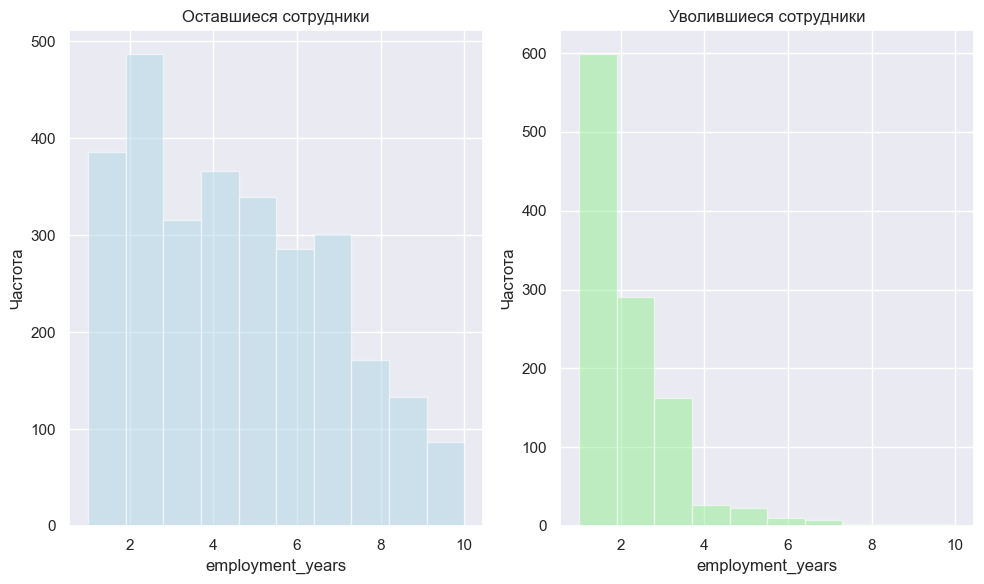

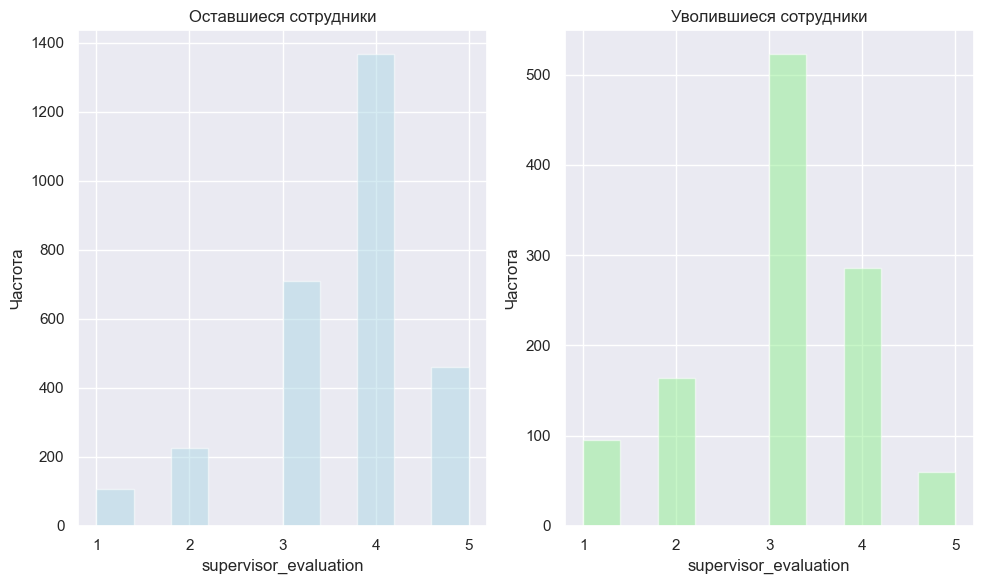

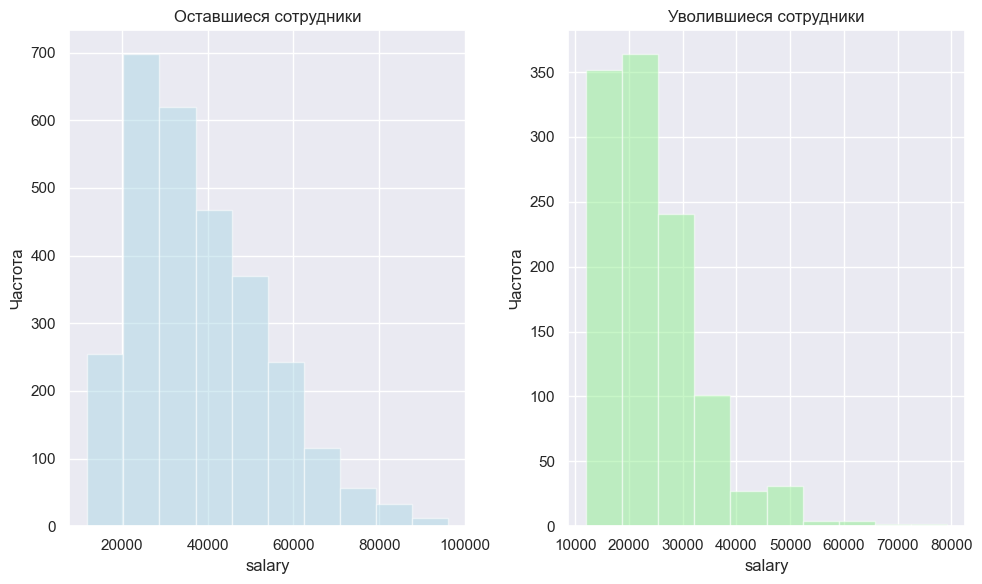

In [66]:
# построим гистограммы
for col in num_features:
    plot_histograms(df_stay, df_quit, col)

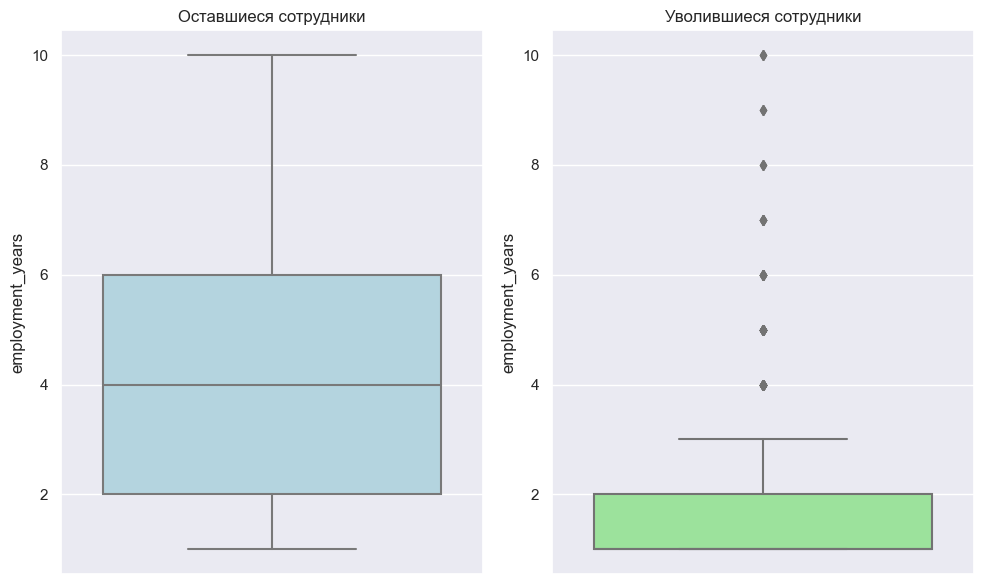

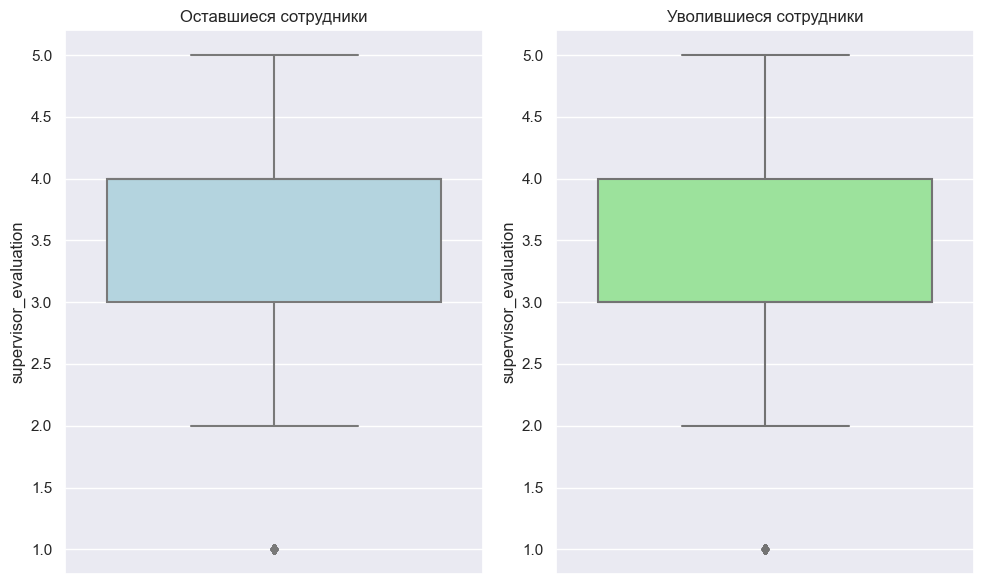

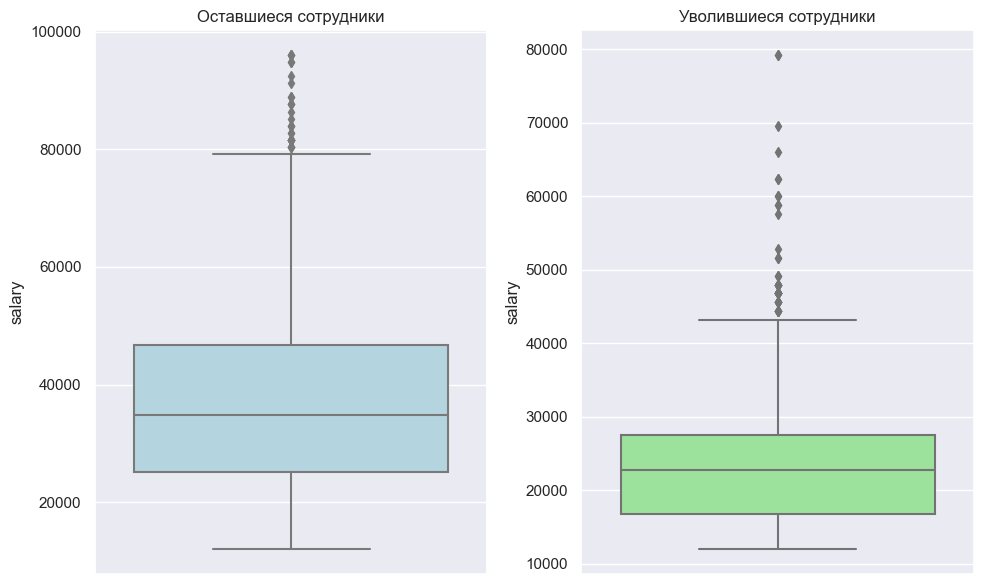

In [67]:
# построим ящики с усами
for col in num_features:
    plot_boxplots(df_stay, df_quit, col)

**Промежуточный вывод по полученным графикам**

В основном из компании уходят сотрудники, которые проработали в ней до 2-х лет, реже увольняются те, которые проработали чуть больше (до 4 лет). Среди уволившихся очень мало или практически нет сотрудников, отдавших компании более 6 лет. 

Уволившиеся сотрудники получали от руководителя больше низких оценок за качество работы, чем высоких.

Реже увольняются сотрудники с высоким уровнем заработной платы: с зарплатой выше `50000` увольнения единичны. Больше всего увольняются сотрудники с заработной платой до `20000`. При этом средняя зарплата уволившихся составляет около `24000`.

Построим графики **зависимости увольнения <u>от категориальных</u> признаков**.

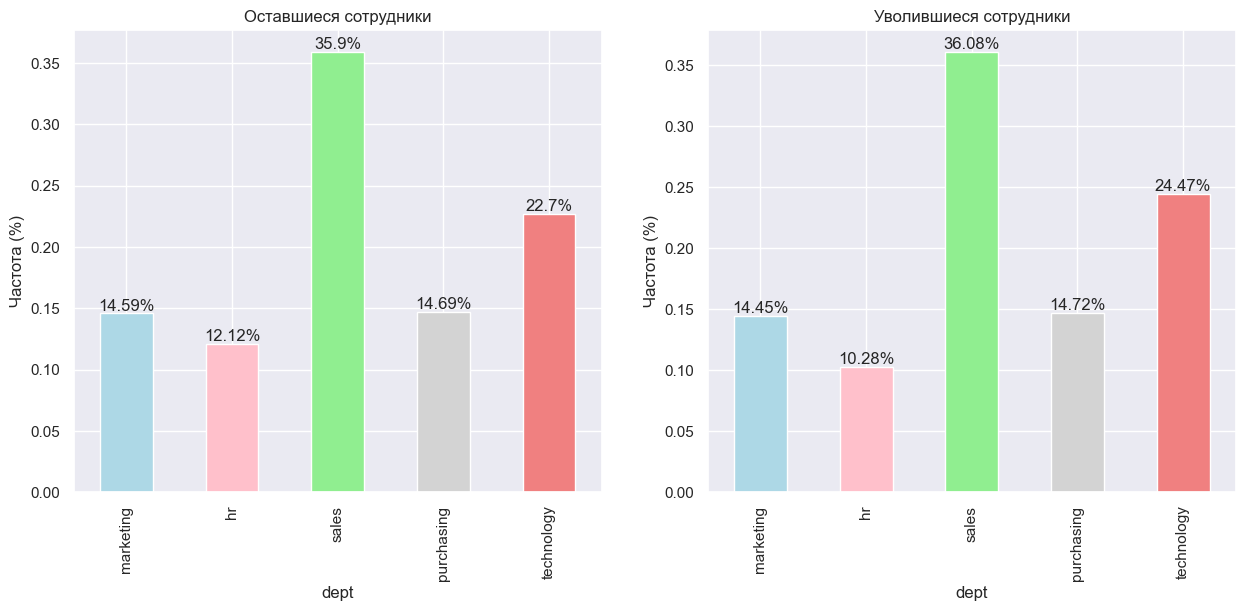

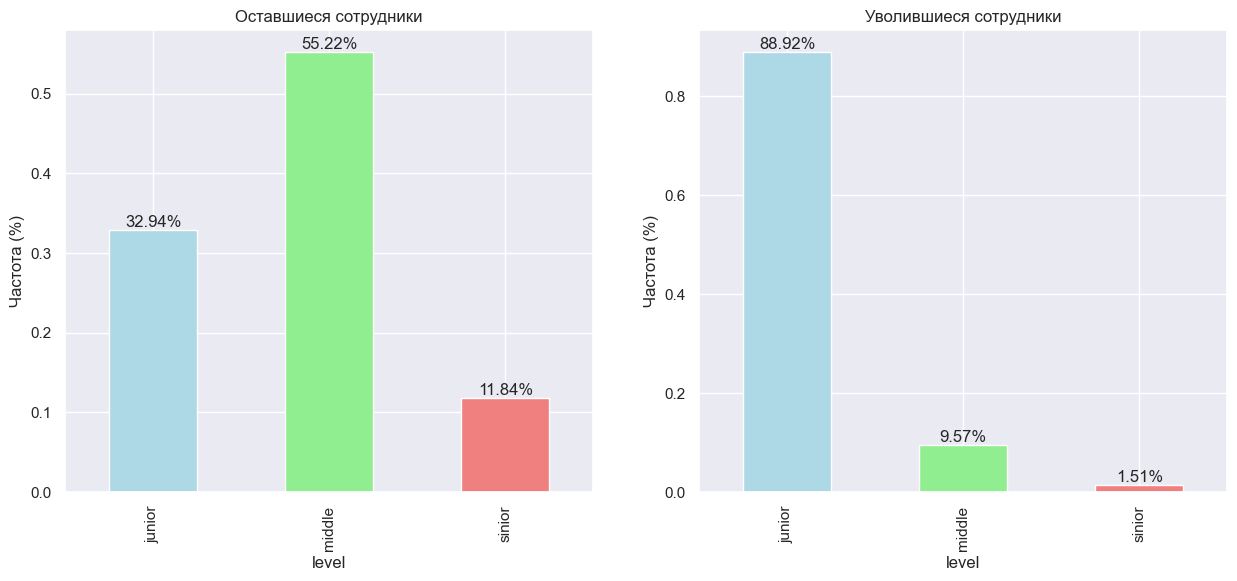

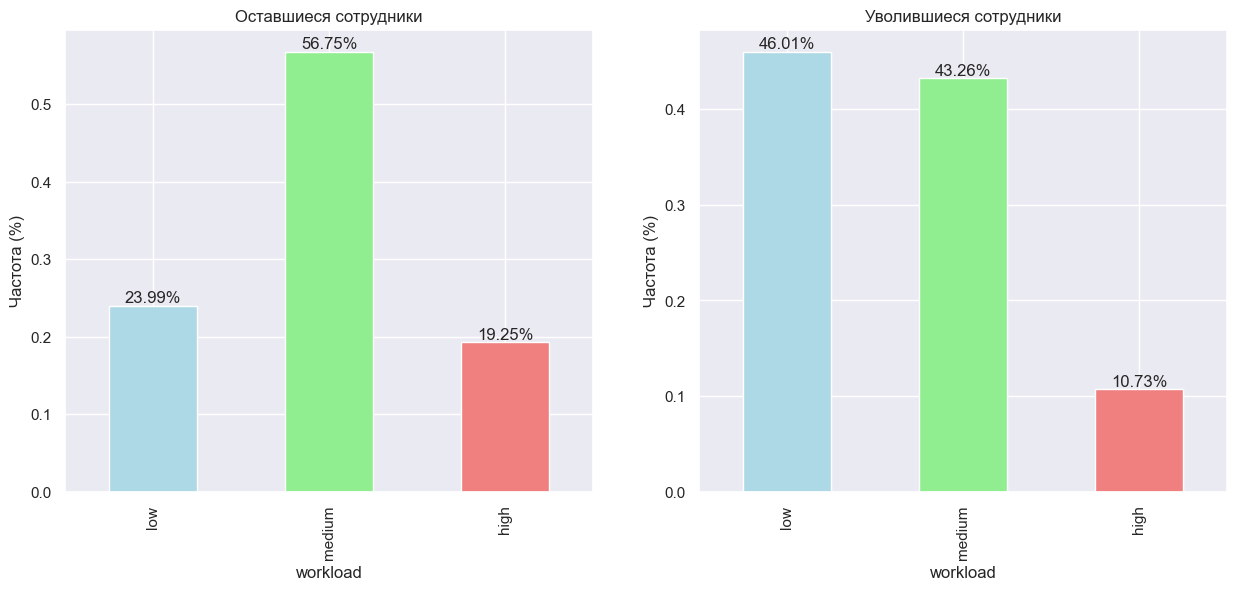

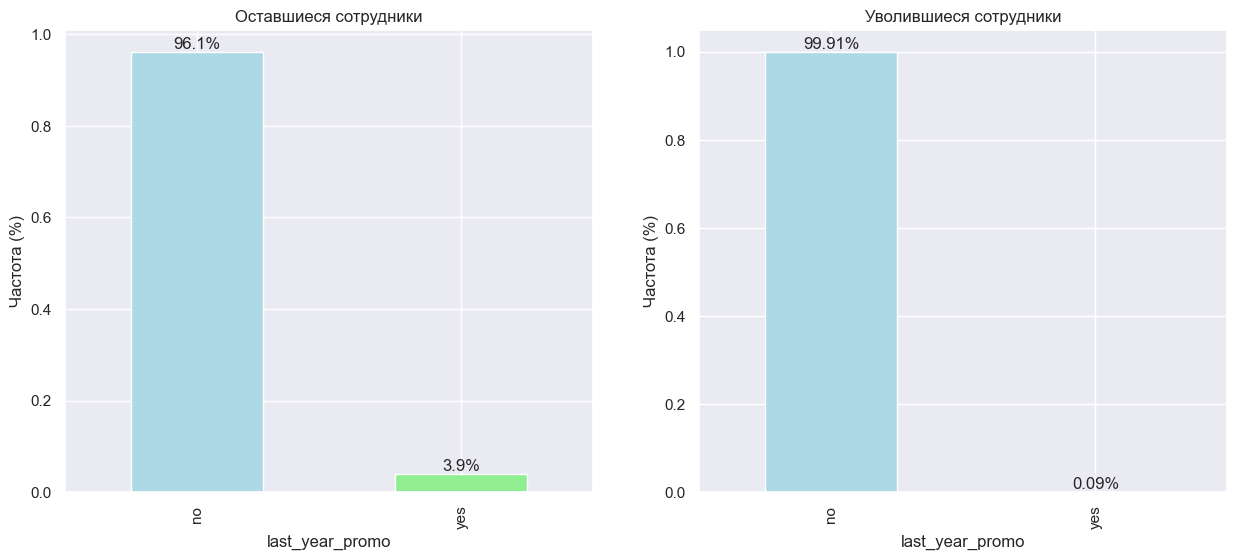

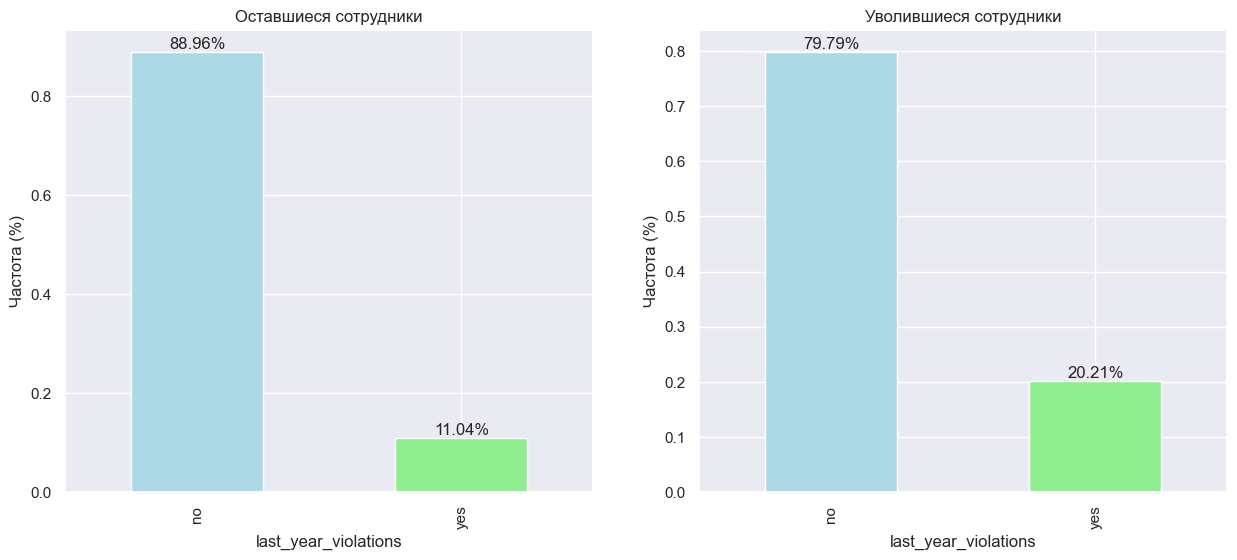

Графики для целевого признака 'quit' не строим.


<Figure size 1500x600 with 0 Axes>

In [68]:
# построим столбчатые диаграммы для категориальных признаков
for col in cat_features:
    plot_categorical_bar_chart(df_stay, df_quit, col)

**Промежуточный вывод по полученным графикам**

Во всех представленных в компании отделах сотрудники увольняются примерно одинаково, нет каких-то выдающихся в этом вопросе отделов.

Гораздо реже увольняются опытные сотрудники и специалисты высокого уровня и руководители. Увольняются в основном начинающие карьеру работники с низкой и средней рабочей нагрузкой. 

Практически все уволившиеся, за исключением нескольких сотрудников, не получали повышения по службе за последний год.

Сотрудники, нарушающие трудовой договор, гораздо чаще увольняются, чем остаются работать.

**Вывод**

На основании полученных данных можно составить следующий портрет уволившегося сотрудника:
    
* работает в любом отделе компании `не более 2—4 лет`, чаще менее 2-х, является сотрудником с низкой кометенцией (junior),
* имеет ценку своей работы от руководителя `в среднем 3 балла`,
* получает невысокую зарплату (до `20000`), при этом средняя зарплата составляет около `24000`,
* имеет низкую или среднюю рабочую нагрузку,
* не имел повышений в должности за последний год,
* имеет склонность к нарушению условий трудового договора.

#### Проверка утверждения: «уровень удовлетворенности сотрудника работой в компании влияет на то, уволится ли сотрудник»

Построим графики, чтобы проследить взаимосвязь удовлетворенности сотрудника работой и его увольнением. Создадим полный тестовый датафрейм, объединив датафреймы `test_data`, `target_data` и `target_data_for_task_2` (целевой признак из первой задачи) по `id`сотрудников.

In [69]:
full_test_data = test_data.merge(target_data, on='id')
full_test_data.shape

(2000, 10)

In [70]:
full_test_data = full_test_data.merge(target_data_for_task_2, on='id')
full_test_data.shape

(2000, 11)

In [71]:
full_test_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.72
2,467458,sales,middle,low,5,no,no,4,19200,no,0.64
3,418655,sales,middle,low,6,no,no,4,19200,no,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.75


Объединение выполнено успешно.

In [72]:
# проверим наличие явных дубликатов
full_test_data.duplicated().sum()

0

In [73]:
# проверим наличие пропусков
full_test_data.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
job_satisfaction_rate    0
dtype: int64

В полученном датафрейме есть пропуски, обработаем их позднее в пайплайне.

Теперь построим графики — ящики с усами.

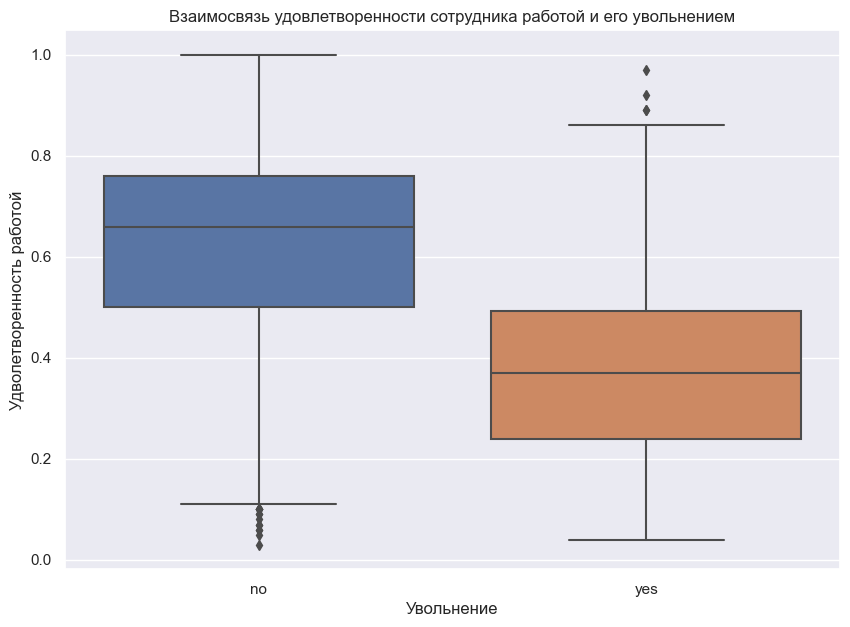

In [74]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=full_test_data, x='quit', y='job_satisfaction_rate')
plt.title('Взаимосвязь удовлетворенности сотрудника работой и его увольнением')
plt.xlabel('Увольнение')
plt.ylabel('Удволетворенность работой')
plt.show()

**Вывод**

В целом с утверждением «уровень удовлетворенности сотрудника работой в компании влияет на то, уволится ли сотрудник» можно согласиться. Сотрудники, которые остались работать в компании, больше удовлетворены своей работой чем те, кто уволился.

Однако есть некоторое количество уволившихся сотрудников, которые были полностью удовлетворены своей работой, это мы видим на графике справа в виде выбросов. А выбросы снизу на левом графике говорят о том, что есть сотрудники (и их даже несколько больше), которые недовольны своей работой, но продолжают работать.

### Добавление нового входного признака

Исходя из пункта выше, мы сделали вывод, что `job_satisfaction_rate` и `quit` действительно связаны, а в первой задаче было получено необходимое значение метрики. Добавим `job_satisfaction_rate`, предсказанный лучшей моделью из первой задачи, к тренировочным и тестовым данным этой задачи.

In [75]:
train_data['job_satisfaction_rate'] = randomized_search.predict(train_data)
full_test_data['job_satisfaction_rate'] = randomized_search.predict(full_test_data)

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


In [76]:
train_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.606667
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.326667
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.337500
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


In [77]:
full_test_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.885000
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.682222
2,467458,sales,middle,low,5,no,no,4,19200,no,0.690000
3,418655,sales,middle,low,6,no,no,4,19200,no,0.713333
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.812500


Готово, столбец удовлетворенности сотрудника работой добавлен успешно в оба датафрейма.

### Подготовка данных

Прежде чем приступить к подготовке данных, построим матрицу Phik для анализа корреляции между переменными в наборах данных. Это необходимо, чтобы обнаружить мультиколлинеарность в данных и, если она есть, устранить лишние признаки.

Рассмотрим матрицу корреляции для датафрейма `train_data`.

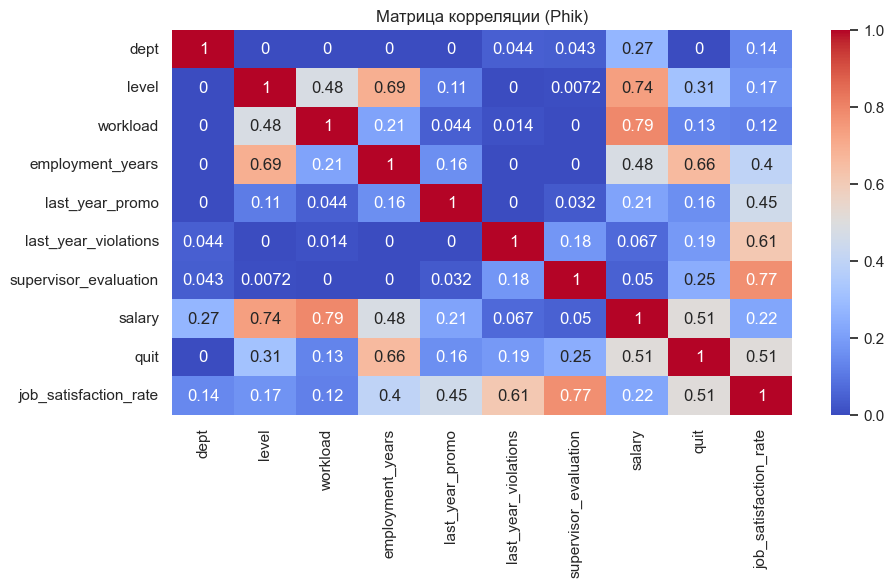

In [78]:
# создадим копию датафрейма без столбца идентификатора сотрудника для построения матрицы корреляции
train_data_copy = train_data.drop('id', axis=1)

# определим столбцы, которые имеют интервальные значения
interval_cols = ['employment_years', 'supervisor_evaluation',
                 'salary', 'job_satisfaction_rate']

# расчет коэффициентов корреляции Phik
correlation_matrix = phik.phik_matrix(train_data_copy, interval_cols=interval_cols)

# построение графика корреляции
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Матрица корреляции (Phik)")
plt.show();

Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от `0.9` до `0.95`. Здесь таких значений мы не наблюдаем.

Однако, можно заметить высокую корреляцию между признаками 'salary' и 'workload' — `0.79`, между 'job_satisfaction_rate' и  'supervisor_evaluation' — `0.78`, между 'salary' и 'level' — `0.74`, заметную корреляцию между 'employment_years' и 'level' — `0.69`, между целевым признаком 'quit' и 'employment_years' — `0.66`, между 'job_satisfaction_rate' и 'last_year_violations' — `0.63`.

Итак, мультиколлинеарности между признаками не обнаружено, приступим к подготовке данных.

Для построения матрицы корреляции был удален признак `id`, поскольку он не несет смысловой нагрузки и добавляет в данные шум. Удалим этот признак из датафрейма, предварительно сохранив его копию с идентификаторами сотрудников.

In [79]:
train_data_with_id = train_data.copy()

Теперь можно безопасно удалить признак `id`.

In [80]:
train_data = train_data.drop('id', axis=1)

In [81]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 312.6+ KB


Проверим наличия явных дубликатов в получившемся датафрейме.

In [82]:
train_data.duplicated().sum()

1413

Итак, мы видим, что явных дубликатов после удаления идентификаторов сотрудников стало `1413`, удалим их.

In [83]:
train_data = train_data.drop_duplicates()

In [84]:
# проверим, что получилось
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 0 to 3998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2587 non-null   object 
 1   level                  2587 non-null   object 
 2   workload               2587 non-null   object 
 3   employment_years       2587 non-null   int64  
 4   last_year_promo        2587 non-null   object 
 5   last_year_violations   2587 non-null   object 
 6   supervisor_evaluation  2587 non-null   int64  
 7   salary                 2587 non-null   int64  
 8   quit                   2587 non-null   object 
 9   job_satisfaction_rate  2587 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 222.3+ KB


Явные дубликаты удалены. Пропусков нет. Продолжим работу.

Поскольку целевой признак `quit` у нас является категориальным, для начала перед разделением данных заменим доступные значения следующим образом: `no` на `0`, `yes` на `1`.

In [85]:
train_data['quit'] = (
    train_data['quit'].apply(lambda x: 1 if x == 'yes' else (0 if x == 'no' else x))
)

full_test_data['quit'] = (
    full_test_data['quit'].apply(lambda x: 1 if x == 'yes' else (0 if x == 'no' else x))
)

Убедимся, что замена выполнена успешно.

In [86]:
train_data.sample(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
2711,technology,junior,high,1,no,no,4,46800,0,0.670
1181,marketing,sinior,medium,6,no,no,5,56400,0,0.538
543,technology,middle,medium,9,no,no,3,49200,0,0.440


In [87]:
full_test_data.sample(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
217,634549,sales,sinior,high,7,no,no,3,68400,0,0.403333
388,478451,sales,junior,medium,1,no,no,3,20400,1,0.173750
226,686405,hr,middle,medium,1,no,no,4,40800,0,0.528000


In [88]:
# создадим списки с названиями признаков для кодировщиков
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [89]:
# выделим обучающие признаки и целевую переменную в обучающих и тренировочных данных

train_features = train_data.drop(['quit'], axis=1)
train_target = train_data['quit']

test_features = full_test_data.drop(['quit'], axis=1)
test_tagret = full_test_data['quit']

print(train_features.shape, train_target.shape)
print(test_features.shape, test_tagret.shape)

(2587, 9) (2587,)
(2000, 10) (2000,)


Приступим к созданию пайплайна подготовки данных (по заданию именно на этом этапе мы должны заполнить пропуски).

In [90]:
# создаем пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
)

# создаем пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'], 
            ['low', 'medium', 'high'], 
            ['yes', 'no'],
            ['no', 'yes']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan
        )
    ),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
     ]
)

# создаем пайплайн для масштабирования числовых признаков
numeric_pipe = Pipeline(
    steps=[
        ('scaler', RobustScaler())
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', numeric_pipe, num_features)
     ],
     remainder='passthrough'
)

Подготовка данных выполнена. Пайплайн подготовки данных создан.

### Обучение моделей

Требуется обучить как минимум три модели. Как минимум для двух из них подобрать гиперпараметры. Проверить качество лучшей модели. Метрика оценки качества в этой задаче — `ROC-AUC`. Критерий успеха: `ROC-AUC ≥ 0.91` на тестовой выборке.

Продолжим создание пайплайна: создание и обучение моделей. Будем использовать `DecisionTreeClassifier()`, `LogisticRegression()`, `KNeighborsClassifier()`.

In [91]:
#создание основного пайплайна
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [92]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2,10),
        'models__min_samples_leaf': range(1,10),
        'models__min_samples_split': range(2,20)
    }, 
 
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [1, 5, 10],
    },
    
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [5, 7, 9], 
    }
]

In [93]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 0 to 3998
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2587 non-null   object 
 1   level                  2587 non-null   object 
 2   workload               2587 non-null   object 
 3   employment_years       2587 non-null   int64  
 4   last_year_promo        2587 non-null   object 
 5   last_year_violations   2587 non-null   object 
 6   supervisor_evaluation  2587 non-null   int64  
 7   salary                 2587 non-null   int64  
 8   job_satisfaction_rate  2587 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 202.1+ KB


In [94]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search.fit(train_features, train_target)

result = pd.DataFrame(randomized_search.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head(10))

print('Лучшая модель и ее параметры:\n\n', randomized_search.best_estimator_)
print('Метрика ROC-AUC лучшей модели на тренировочной выборке:', randomized_search.best_score_)

pred_q = randomized_search.predict_proba(test_features)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(test_tagret, pred_q)}')

,rank_test_score,param_models,mean_test_score,params
5,1,DecisionTreeClassifier(random_state=42),0.898604,"{'models__min_samples_split': 3, 'models__min_samples_leaf': 7, 'models__max_features': 8, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
8,2,DecisionTreeClassifier(random_state=42),0.896397,"{'models__min_samples_split': 18, 'models__min_samples_leaf': 4, 'models__max_features': 4, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
4,3,DecisionTreeClassifier(random_state=42),0.894980,"{'models__min_samples_split': 12, 'models__min_samples_leaf': 4, 'models__max_features': 5, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
0,4,DecisionTreeClassifier(random_state=42),0.894133,"{'models__min_samples_split': 18, 'models__min_samples_leaf': 8, 'models__max_features': 6, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
7,5,DecisionTreeClassifier(random_state=42),0.893576,"{'models__min_samples_split': 18, 'models__min_samples_leaf': 3, 'models__max_features': 5, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
2,6,DecisionTreeClassifier(random_state=42),0.891688,"{'models__min_samples_split': 10, 'models__min_samples_leaf': 3, 'models__max_features': 3, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
9,7,DecisionTreeClassifier(random_state=42),0.886590,"{'models__min_samples_split': 8, 'models__min_samples_leaf': 4, 'models__max_features': 5, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}"
3,8,DecisionTreeClassifier(random_state=42),0.886186,"{'models__min_samples_split': 9, 'models__min_samples_leaf': 1, 'models__max_features': 2, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
1,9,DecisionTreeClassifier(random_state=42),0.874232,"{'models__min_samples_split': 16, 'models__min_samples_leaf': 3, 'models__max_features': 7, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
6,10,DecisionTreeClassifier(random_state=42),0.845697,"{'models__min_samples_split': 18, 'models__min_samples_leaf': 8, 'models__max_features': 4, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"


Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                           

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


Итак, лучшая модель `DecisionTreeClassifier()` с метрикой `ROC-AUC = 0.898`. По заданию критерий успеха: `ROC-AUC ≥ 0.91` на тестовой выборке. Мы достигли `ROC-AUC = 0.929`. Уже очень хороший результат.

Попробуем еще улучшить модель путем отбора признаков.

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


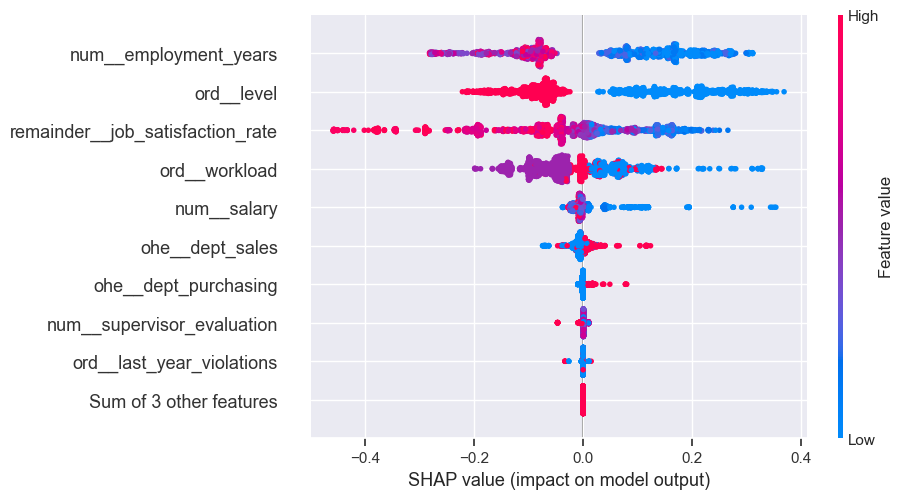

In [95]:
# преобразуем данные обучающей выборки
X_train = pipe_final.named_steps['preprocessor'].fit_transform(train_features)

# создадим объект explainer
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train)

# преобразуем данные тестовой выборки
X_test = pipe_final.named_steps['preprocessor'].transform(test_features)

# получим имена признаков
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

# создадим датафрейм для тестовых данных с именами признаков
X_test = pd.DataFrame(X_test, columns=feature_names)

# посчитаем значения SHAP для тестовых данных
shap_values = explainer(X_test)

# визуализируем значения SHAP на графике «осиное гнездо»
shap.plots.beeswarm(shap_values[:, :, 1])

Все признаки после `level` и ниже обтросим и еще раз обучим модель и подберем гиперпараметры.
Будем использовать `DecisionTreeClassifier()`, `KNeighborsClassifier()` и `SVC()` вместо `LogisticRegression()`.

In [96]:
selected_columns = ['employment_years', 'level', 'job_satisfaction_rate', 'workload', 'salary']

In [97]:
train_features = train_features[selected_columns]
test_features = test_features[selected_columns]

In [98]:
# создадим списки с названиями признаков для кодировщиков
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'job_satisfaction_rate', 'salary']

In [99]:
# создаем пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'], 
            ['low', 'medium', 'high']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan
        )
    ),
    ('simpleImputer_after_ord', SimpleImputer(strategy='most_frequent'))
     ]
)

# создаем пайплайн для масштабирования числовых признаков
numeric_pipe = Pipeline(
    steps=[
        ('scaler', RobustScaler())
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ord_pipe, ord_columns),
     ('num', numeric_pipe, num_columns)
     ],
    remainder='passthrough'
)

In [100]:
# создание основного пайплайна
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [101]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(1, 6),
        'models__min_samples_leaf': range(1, 10),
        'models__min_samples_split': range(2, 20)
    }, 
    
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [5, 7, 9], 
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['linear', 'rbf', 'sigmoid'],
    }
]

In [102]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE)

randomized_search.fit(train_features, train_target)

result = pd.DataFrame(randomized_search.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head(10))

print('Лучшая модель и ее параметры:\n\n', randomized_search.best_estimator_)
print('Метрика ROC-AUC лучшей модели на тренировочной выборке:', randomized_search.best_score_)

pred_q = randomized_search.predict_proba(test_features)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(test_tagret, pred_q)}')

,rank_test_score,param_models,mean_test_score,params
6,1,DecisionTreeClassifier(random_state=42),0.893894,"{'models__min_samples_split': 16, 'models__min_samples_leaf': 1, 'models__max_features': 5, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
8,2,DecisionTreeClassifier(random_state=42),0.890907,"{'models__min_samples_split': 3, 'models__min_samples_leaf': 7, 'models__max_features': 4, 'models__max_depth': 9, 'models': DecisionTreeClassifier(random_state=42)}"
5,3,DecisionTreeClassifier(random_state=42),0.889265,"{'models__min_samples_split': 12, 'models__min_samples_leaf': 3, 'models__max_features': 4, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
0,4,DecisionTreeClassifier(random_state=42),0.888782,"{'models__min_samples_split': 18, 'models__min_samples_leaf': 8, 'models__max_features': 5, 'models__max_depth': 10, 'models': DecisionTreeClassifier(random_state=42)}"
2,5,DecisionTreeClassifier(random_state=42),0.884790,"{'models__min_samples_split': 10, 'models__min_samples_leaf': 3, 'models__max_features': 4, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}"
7,6,DecisionTreeClassifier(random_state=42),0.879289,"{'models__min_samples_split': 12, 'models__min_samples_leaf': 4, 'models__max_features': 1, 'models__max_depth': 9, 'models': DecisionTreeClassifier(random_state=42)}"
3,7,DecisionTreeClassifier(random_state=42),0.874562,"{'models__min_samples_split': 8, 'models__min_samples_leaf': 3, 'models__max_features': 3, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}"
4,8,DecisionTreeClassifier(random_state=42),0.873658,"{'models__min_samples_split': 9, 'models__min_samples_leaf': 1, 'models__max_features': 3, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}"
9,9,DecisionTreeClassifier(random_state=42),0.864223,"{'models__min_samples_split': 18, 'models__min_samples_leaf': 8, 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
1,10,DecisionTreeClassifier(random_state=42),0.829376,"{'models__min_samples_split': 16, 'models__min_samples_leaf': 3, 'models__max_features': 1, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"


Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                 

После отбора признаков обе метрики снизились, значит в качестве лучшей модели выберем предыдущую, полученную до отбора признаков.
    
**Вывод**

В результате выбрана лучшая модель — DecisionTreeClassifier() со следующими параметрами:

max_depth=6,
max_features=8,
min_samples_leaf=7,
min_samples_split=3,
random_state=42.

Метрика ROC-AUC лучшей модели на тренировочной выборке составляет с округлением `0.9`, что говорит хороших предсказательных способностях модели на обучающих данных. Метрика ROC-AUC на тестовой выборке составляет с округлением `0.93`, то есть модель справляется хорошо и с тестовыми данными.

### Выводы

Лучшей моделью, как и в решении первой задачи, стало дерево решений `DecisionTreeClassifier()`. В связи с этим можно предположить, что предоставленный набор данных обладает такими характеристиками, на которых дерево решений справляется наилучшим образом. Эта модель способна делать разделение данных на основе нескольких признаков одновременно, если есть нелинейные зависимости, также может игнорировать неинформативные или незначительные признаки при построении дерева.

## Общий вывод

В данном проекте предполагалось решение двух задач, в результате выполнения которых нужно было построить две модели: первая модель для предсказания уровня удовлетворенности сотрудника работой, вторая модель для предсказания увольнения сотрудника из комании.

В рамках проекта был проведен исследовательский анализ данных, в ходе которого были обнаружены выбросы и пропуски. При выполнении предобработки было принято решение оставить выбросы без изменений (для того, чтобы модель лучше обучилась), а пропуски были заменены на наиболее часто встречающиеся значения для обеих задач.

Для предсказания уровня удовлетворенности сотрудников было обучено четыре модели: DecisionTreeRegressor(), LinearRegression() и ElasticNet Regression(). По результатам анализа дерево решений `DecisionTreeRegressor()` показало наилучшую производительность (параметрамs: `ax_depth=33`, `max_features=45`, `min_samples_leaf=3`, `random_state=42`), с метрикой `SMAPE` на тренировочной выборке `15.2` и на тестовой выборке `13.4`. С помощью этой модели были сделаны предсказания уровня удовлетворенности сотрудников и в данные добавлен новый признак для решения второй задачи.

При выполнении второй задачи было сделано предположение о том, что сотрудники с низким уровнем удовлетворенности больше склонны к увольнению. Был проведен анализ данных, в результате которого это предположение подтвердилось, однако были обнаружены уволившиеся сотрудники с высокой удовлетворенностью работой и оставшиеся сотрудники с низким уровнем удовлетворенности. Для предсказания увольнения были использованы модели DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier(), после обучения и получения метрик стало понятно, что модель и так достаточно хорошо справляется с классификацией, но было принято решение выполнить отбор наиболее важных признаков для улучшения качества предсказания. После выполнения графического анализа было принято решение оставить такие признаки как длительность работы в компании, заработная плата, уровень удовлетворенности работой, рабочая нагрузка и уровень квалификации, остальные признаки в обучении не учитывались. На этот раз использовались модели DecisionTreeClassifier(), KNeighborsClassifier() и SVC() вместо LogisticRegression(). По результатам анализа дерево решений DecisionTreeClassifier() показало наилучшую производительность, но метрики снизились как на тренировочной, так и на тестовой выборках, в результате было принято решение выбрать лучшей модель `DecisionTreeClassifier()` до отбора признаков (с параметрами: `max_depth=6`, `max_features=8`, `min_samples_leaf=7`, `min_samples_split=3`, `random_state=42`), с метрикой на тренировочной выборке `ROC-AUC = 0.9` и на тестовой выборке `ROC-AUC = 0.93`

Теперь мы можем предложить компании модель, способную прогнозировать уровень удовлетворенности сотрудников и вероятность их увольнения. Однако уже сейчас можно дать некоторые рекомендации: особое внимание следует уделить новым сотрудникам, поскольку именно среди них достаточно высокий уровень увольнений. Возможно, повышение заработной платы (это второй по важности признак при прогнозировании увольнения) поможет улучшить их настроение и повлиять на их решение остаться в компании на более длительный срок. Увеличение количества довольных и мотивированных сотрудников поспособствует улучшению рабочего процесса и уменьшению вероятности увольнений. Стабильное и приятное рабочее окружение может сыграть важную роль в удержании талантливых сотрудников и повышении их лояльности к компании.